In [80]:
import warnings
warnings.filterwarnings("ignore")

In [81]:
import pandas as pd
import numpy as np
import seaborn as sns

import matplotlib.pyplot as plt
%matplotlib inline

from statsmodels.tsa.stattools import adfuller
from statsmodels.tools.eval_measures import rmse, aic
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

## Step 1: quick look

In [82]:
filepath = 'weather_christchurch_daily.csv'

data = pd.read_csv(filepath, parse_dates=['time_index'], index_col='time_index')

data = data.sort_index()

data = data.asfreq('D')

data = data.drop(['weather_status_christchurch'], axis=1)

# Assuming 'df' is your DataFrame
data.columns = data.columns.str.replace('_christchurch', '')
data.columns = data.columns.str.replace('temperatures_', 'temp_')

tmp = data.drop(['rain_mm', 'temp_max_c', 'temp_min_c'], axis=1)

df = tmp.copy()

print(df.info())
df.tail()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1733 entries, 2019-01-01 to 2023-09-29
Freq: D
Data columns (total 1 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   wind_speed_km  1666 non-null   float64
dtypes: float64(1)
memory usage: 27.1 KB
None


,wind_speed_km
time_index,
2023-09-25,15.0
2023-09-26,22.0
2023-09-27,25.0
2023-09-28,25.0
2023-09-29,25.0


In [83]:
df.describe()

,wind_speed_km
count,1666.000000
mean,21.070228
std,8.368925
min,5.000000
25%,15.000000
50%,20.000000
75%,26.000000
max,72.000000


## Step 2: EDA

**1. Missing values**

In [84]:
import pandas as pd
from tabulate import tabulate

# Assuming 'df' is your DataFrame
missing_values = df.isnull().sum()
missing_indices = missing_values[missing_values > 0].index

# Create a table of missing values
table_data = []
for index in missing_indices:
    missing_count = df[index].isnull().sum()
    percent = (missing_count / len(df)) * 100
    table_data.append([index, missing_count, f"{percent:.2f}%"])

# Specify table headers
table_headers = ["Feature", "Missing Count", "Percentage"]

# Display the table
table = tabulate(table_data, headers=table_headers, tablefmt="pretty")
print(table)

+---------------+---------------+------------+
|    Feature    | Missing Count | Percentage |
+---------------+---------------+------------+
| wind_speed_km |      67       |   3.87%    |
+---------------+---------------+------------+


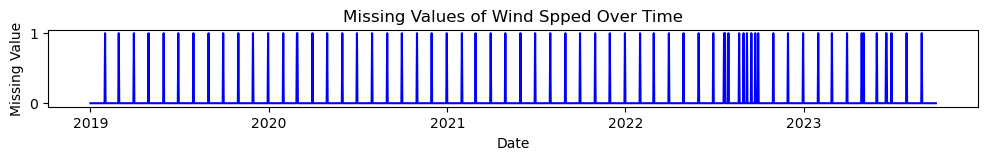

In [85]:
# Plotting missing values over time for each feature
plt.figure(figsize=(12, 1))
plt.plot(df.index, df['wind_speed_km'].isnull(), color='blue')

plt.title('Missing Values of Wind Spped Over Time')
plt.xlabel('Date')
plt.ylabel('Missing Value')
plt.show()

In [86]:
missing_indices = df[df.isnull().any(axis=1)].index
print("Time indices of missing values:")
print(missing_indices)

Time indices of missing values:
DatetimeIndex(['2019-01-31', '2019-02-28', '2019-03-31', '2019-04-30',
               '2019-05-31', '2019-06-30', '2019-07-31', '2019-08-31',
               '2019-09-30', '2019-10-31', '2019-11-30', '2019-12-31',
               '2020-01-31', '2020-02-28', '2020-02-29', '2020-03-31',
               '2020-04-30', '2020-05-31', '2020-06-30', '2020-07-31',
               '2020-08-31', '2020-09-30', '2020-10-31', '2020-11-30',
               '2020-12-31', '2021-01-31', '2021-02-28', '2021-03-31',
               '2021-04-30', '2021-05-31', '2021-06-30', '2021-07-31',
               '2021-08-31', '2021-09-30', '2021-10-31', '2021-11-30',
               '2021-12-31', '2022-01-31', '2022-02-28', '2022-03-31',
               '2022-04-30', '2022-05-31', '2022-06-30', '2022-07-22',
               '2022-07-23', '2022-07-24', '2022-07-31', '2022-08-22',
               '2022-08-31', '2022-09-07', '2022-09-16', '2022-09-24',
               '2022-09-30', '2022-10-31', '2

In [87]:
## fill missing values on the temporary dataset 
df = df.fillna(method='ffill').fillna(method='bfill')

**2. Time Series Overview**

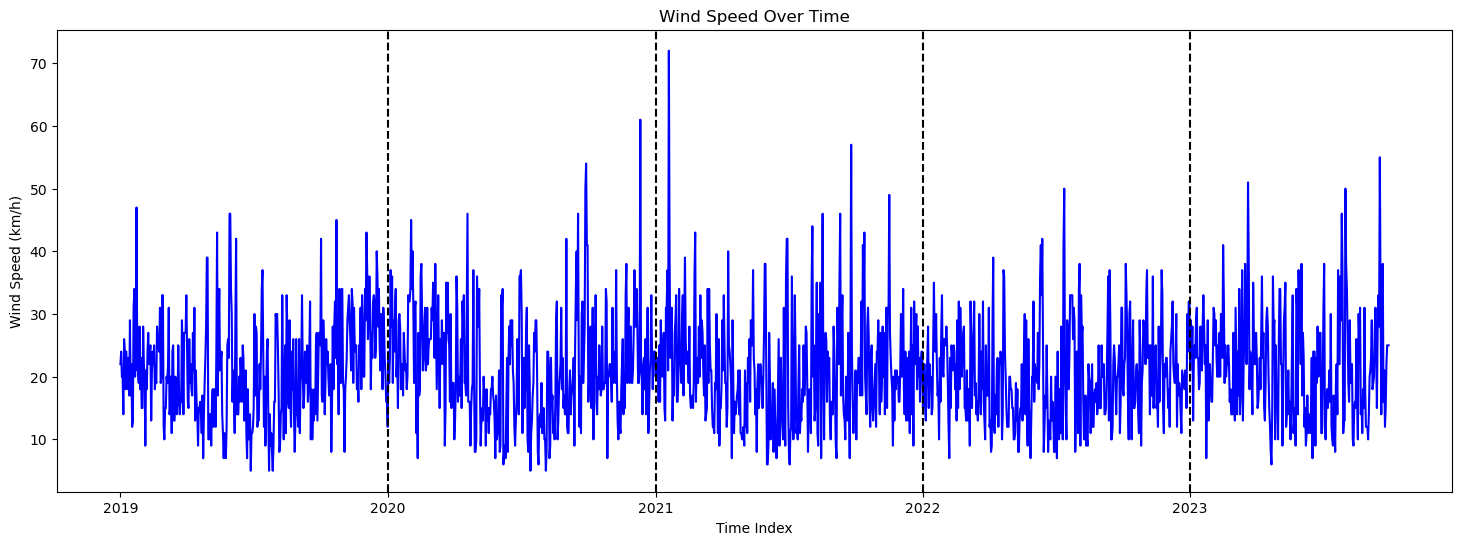

In [88]:
# Visualization: Time Series Line Charts of Wind Speed
data = df['wind_speed_km']

plt.figure(figsize=(18, 6))
plt.plot(data, label='Original', color='blue')

xcoords = pd.to_datetime(['2020-01-01', '2021-01-01', '2022-01-01', '2023-01-01'])
for xc in xcoords:
    plt.axvline(x=xc, color='black', linestyle='--')

# Decorations
plt.title('Wind Speed Over Time')
plt.xlabel('Time Index')
plt.ylabel('Wind Speed (km/h)')
plt.show()

The Wind Speed dataset has no clear trend but seasonality. It has a continuous repeating pattern. It is considerable to apply seasonal differencing in order to remove the seasonal pattern and make the series stationary.

The Augmented Dickey-Fuller (ADF) test aims to reject the null hypothesis that the given time-series data is non-stationary. Let's do it.

In [89]:
result = adfuller(df)
print('p-value: ', round(result[1], 3))

p-value:  0.0


As the p-valuee is less than a significance level of 0.05, we reject the null hypothesis. It means that the trend and seasonality effects have been addressed, and further differencing may not be required. In other words, the data is stationary and the order of differencing (d) is 0.

**4. AutoCorrelation**

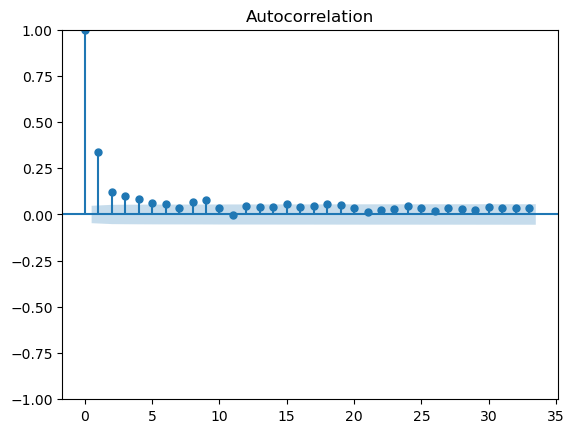

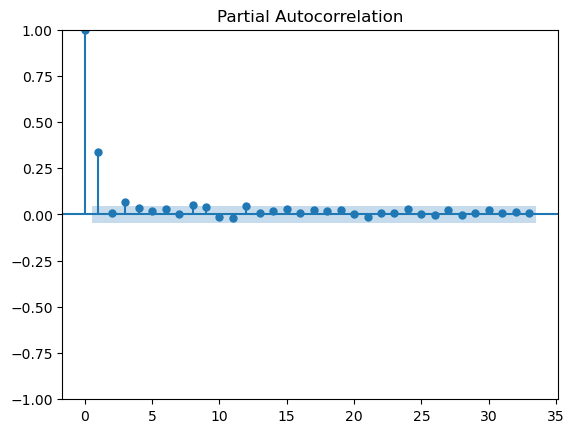

In [90]:
plot_acf(df)
plot_pacf(df)
plt.show()

By looking at the PACF plot, there are some points out of the 99% confidence band. A positive correlation with the lag value of 1 is the most significant. Thus, we consider 'p' to be 1.

From the ACF plot, the moving average (MA) parameter can be set to 1.

Note: try to look through 365 lag values. If the autocorrelation function of 
- a daily time series has a peak at the lag value of 365, then there is a yearly seasonality in the data.
- a monthly time series has a peak at the lag value of 12, then there is a yearly seasonality in the data.

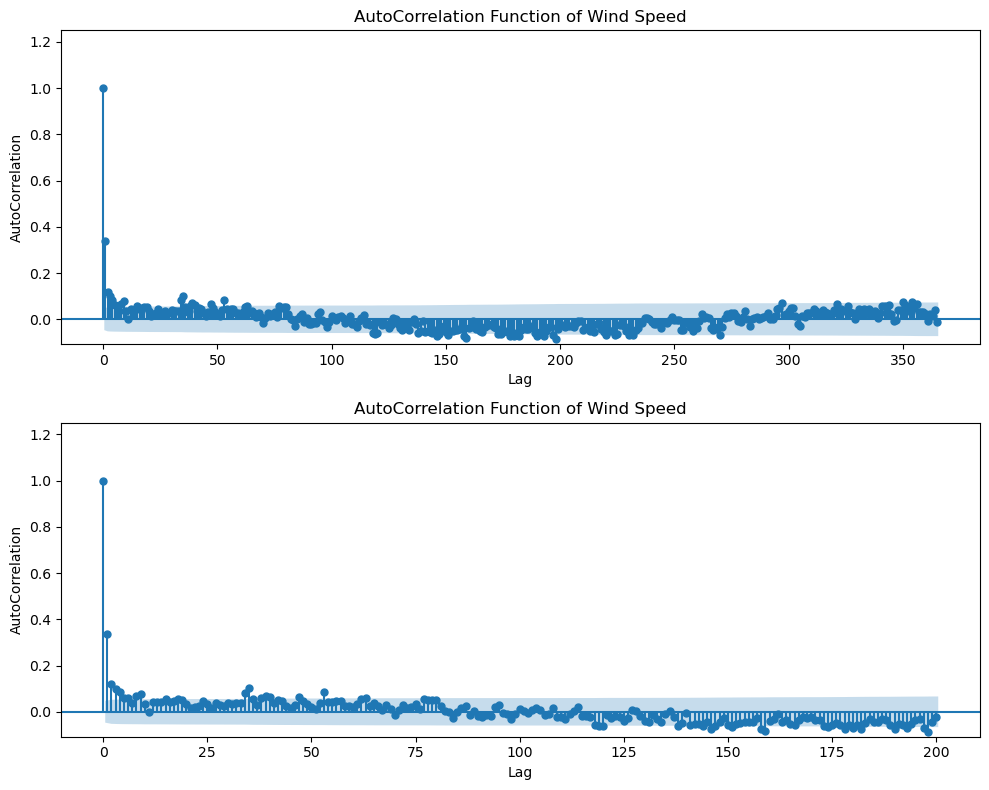

In [91]:
## AutoCorrelation Function (ACF) and Partial Autocorrelation (PACF)
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig, axes = plt.subplots(2, 1, figsize=(10, 8))

# Flatten axes for iteration
axes = axes.flatten()

plot_acf(df, lags=365, ax=axes[0], title=f'AutoCorrelation Function of Wind Speed', auto_ylims=True)
axes[0].set_xlabel('Lag')
axes[0].set_ylabel('AutoCorrelation')

plot_acf(df, lags=200, ax=axes[1], title=f'AutoCorrelation Function of Wind Speed', auto_ylims=True)
axes[1].set_xlabel('Lag')
axes[1].set_ylabel('AutoCorrelation')

plt.tight_layout()
plt.show()

**5. Seasonal Decomposition**

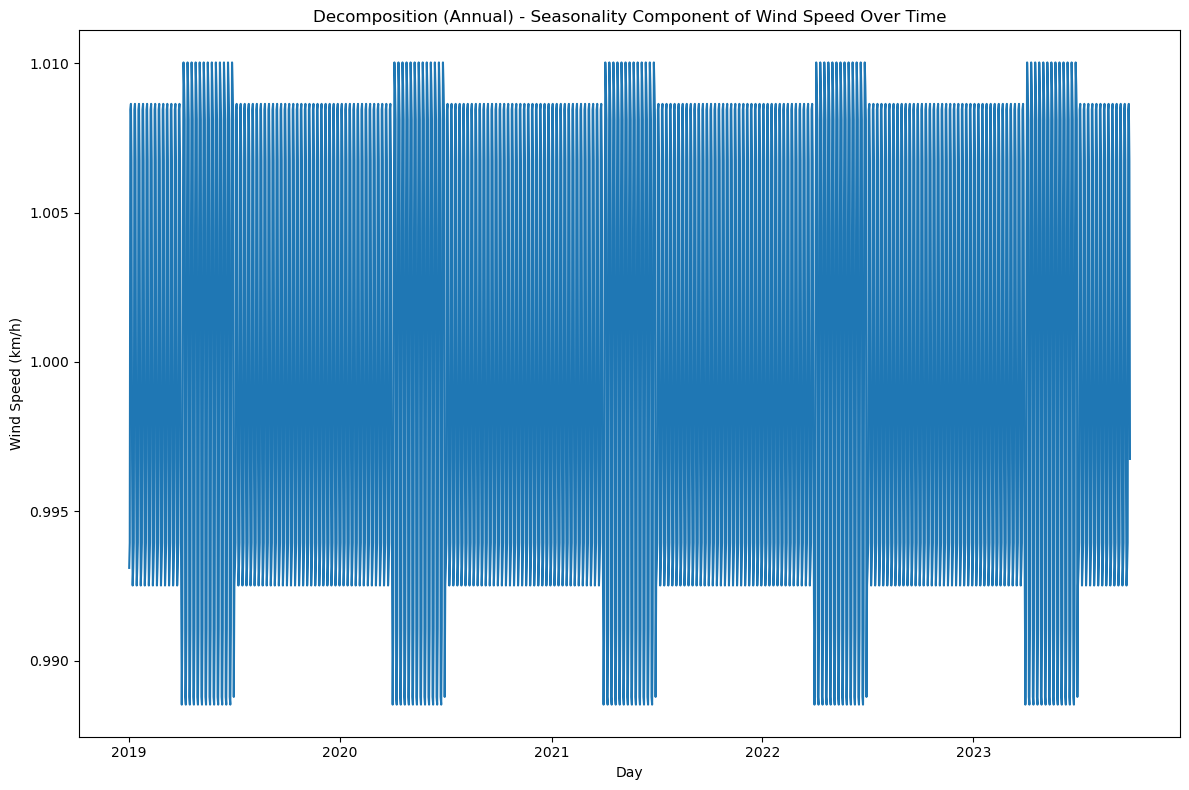

In [92]:
from statsmodels.tsa.seasonal import seasonal_decompose

result_weekly = seasonal_decompose(df, model='multiplicative', period=7) # weekly
result = seasonal_decompose(result_weekly.seasonal.dropna(), model='multiplicative', period=365) # annual

# Plot the results
plt.figure(figsize=(12, 8))

plt.plot(result.seasonal)
plt.ylabel('Wind Speed (km/h)')
plt.title('Decomposition (Annual) - Seasonality Component of Wind Speed Over Time')
plt.xlabel('Day')
plt.tight_layout()
plt.show()

There is an annual seasonal pattern for the time series showing the dailly wind power. The wind speed reaches high volatiliy in the second quarter of the year. The other quarters have the same variance of the wind speed. 

## Step 3: Modeling

The dataset is only a set of wind speed data. The training data consists of observations from January 2019 to June 2023. The testing data includes the most recent 60 days' observations from July 2023 to August 2023.

Algorithms: ARIMA, SARIMA, Facebook Prophet

p=1, q = 1 or q = 2, and d=0 => possible tries: ARIMA(1,0,1) and ARIMA(1,0,2)

m = 365 => SARIMA

**1. ARIMA model**

In [93]:
nobs = 60
train, test = df[:-nobs], df[-nobs:]

In [94]:
from statsmodels.tsa.arima.model import ARIMA

arima_model = ARIMA(train, order=(1,0,1))
model = arima_model.fit() # a trained model used for evaluation and inference
print(model.summary())

                               SARIMAX Results                                
Dep. Variable:          wind_speed_km   No. Observations:                 1673
Model:                 ARIMA(1, 0, 1)   Log Likelihood               -5826.529
Date:                Sun, 26 Nov 2023   AIC                          11661.058
Time:                        16:40:58   BIC                          11682.748
Sample:                    01-01-2019   HQIC                         11669.094
                         - 07-31-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         21.0651      0.324     65.012      0.000      20.430      21.700
ar.L1          0.3717      0.063      5.903      0.000       0.248       0.495
ma.L1         -0.0408      0.068     -0.604      0.5

As we kept the value of the MA parameter as 1, we have one trained coefficient for MA and one for AR

The Akaike Information Criteria or AIC is a measure for testing the goodness of how fit the model is mathematically. Information Criteria scores measure the amount of information lost by training and generalizing the ARIMA model. The AIC must be as low as possible. To reduce AIC, we can try changing the p and q values or using training techniques like k-cross-validation

In [95]:
arima_model = ARIMA(train, order=(1,0,3))
model = arima_model.fit() # a trained model used for evaluation and inference
print(model.summary())

                               SARIMAX Results                                
Dep. Variable:          wind_speed_km   No. Observations:                 1673
Model:                 ARIMA(1, 0, 3)   Log Likelihood               -5815.609
Date:                Sun, 26 Nov 2023   AIC                          11643.219
Time:                        16:40:59   BIC                          11675.753
Sample:                    01-01-2019   HQIC                         11655.273
                         - 07-31-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         21.0670      0.697     30.225      0.000      19.701      22.433
ar.L1          0.9826      0.010     94.434      0.000       0.962       1.003
ma.L1         -0.6624      0.024    -27.591      0.0

Changing the value of q to 2, 3, or 4 reduced the AIC value. We choose the ARIMA(1,0,3)

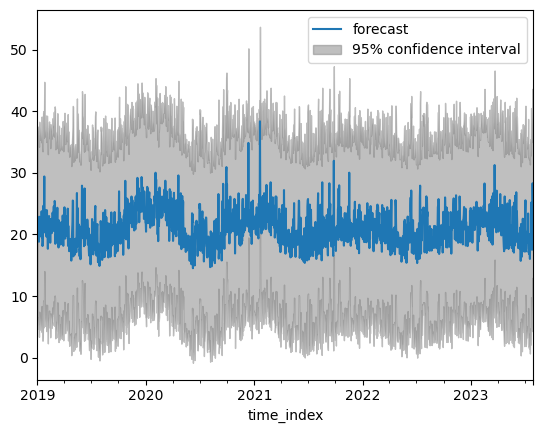

In [96]:
from statsmodels.graphics.tsaplots import plot_predict

min_date = train.index.min()
max_date = train.index.max()

plot_predict(model, start=min_date, end=max_date)
plt.show()

Since our test set is of size 60, we predict 60 instances that occur right after the last timestamp of the training set.

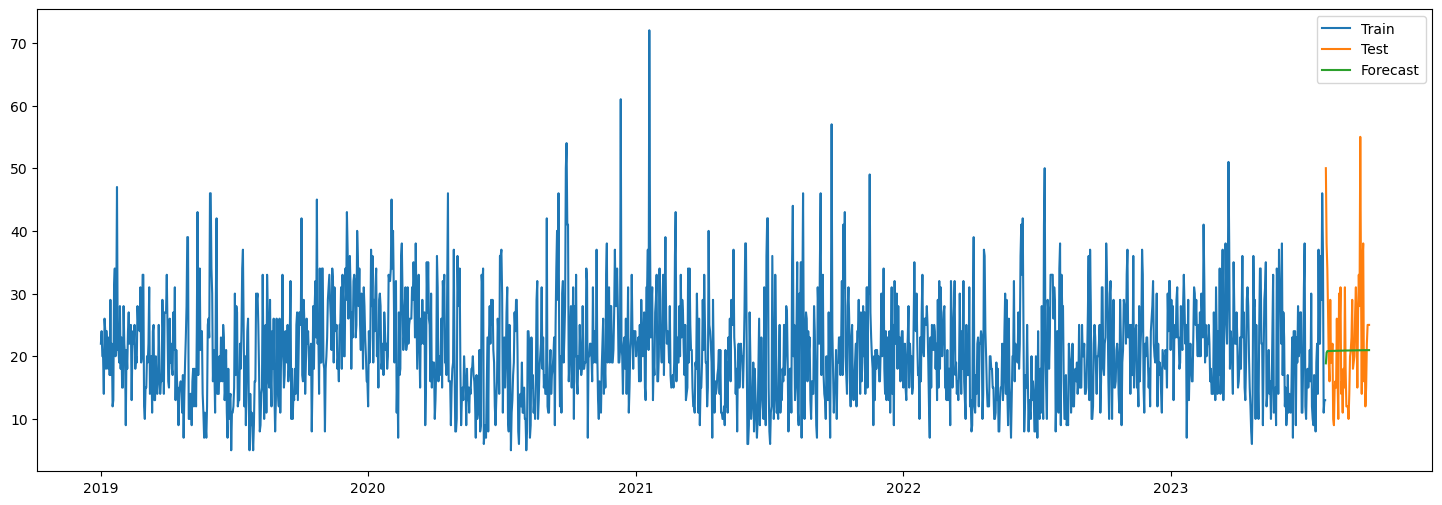

In [97]:
forecast = model.forecast(steps=nobs)

plt.figure(figsize=(18, 6))
plt.plot(train.index, train, label='Train')
plt.plot(test.index, test, label='Test')
plt.plot(forecast.index, forecast, label='Forecast')
plt.legend()
plt.show()

The metrics, that are MAPE, MAE, MINMAX, MPE, RMSE, are popular to measure errors in general regression models. In the case of time-series models, change in values over time, and metrics like MAE or MAPE do not easily capture the scale of the values. MAE finds the absolute difference between predicted and actual values and averages them over all samples in the test set. Over time, the change in values is lost, and the context of the set's actual values is also significant. For example, an MAE of 100 would be a good score if the actual values are of the order of 10,000s but a terrible score if the values lie in the hundreds. The same goes for RMSE. However, MAPE is scale-independent and is reliable for such a changing time series as long as the value never reaches 0 else, the score will be undefined. A better alternative is the Mean Absolute Scaled Error (MASE) as per general consensus.

MASE considers the data the model was trained on (a_i) in the form of 1st order changes or differences. This makes it a good measure for time-series data irrespective of scale or time.

In [98]:
# Import libraries
from sklearn.metrics import mean_absolute_error

def mean_absolute_scaled_error(actual, predicted):
    """
    Calculate MASE (Mean Absolute Scaled Error).
    """
    mae = mean_absolute_error(actual, predicted)
    naive_error = np.mean(np.abs(actual[1:] - actual[:-1]))
    return mae / naive_error

# Calculate MASE
mase = mean_absolute_scaled_error(test.values, forecast.values)
print("MASE:", round(mase, 2))

MASE: 1.01


A MASE value of 1.02 suggests that, on average, the ARIRMA(1,0,3) model's predictions are about 1.02 times as accurate as the naive forecast (a simple forecast that uses the previous observed value as the predictin for the next period). In other words, the model's predictions are slightly worse, on average than a naive forecast. 

In [99]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
import numpy as np

#mean absolute error
mae = mean_absolute_error(test, forecast)

#root mean square error
mse = mean_squared_error(test, forecast)
rmse = np.sqrt(mse)

#mean absolute percentage error
mape = mean_absolute_percentage_error(test, forecast) * 100

print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"MAPE: {mape:.2f}%")

MAE: 7.38
RMSE: 9.61
MAPE: 36.66%


It gave 7.38. It means the average error in our actual values and the predicted value is 7.38.

**2. SARIMA model**

Step 1: find p,d, and q values

We can see that there is a seasonal pattern to this data. So, we usee SARIMA as the most appropriate algorithm for this data. Before using SARIMA, we need to find the p,d, and q values first.

In [ ]:
## don't run it because it take the whole day!!!!
from pmdarima.arima import auto_arima

model = auto_arima(df, seasonal=True, m=365, suppress_warnings=True)
print(model.order)

Note:
- m: # of obs. per seasonal cycle, and (2)generally requires subject matter knowledge of the data
    - 1:non-seasonal, 4:quarterly, 7: daily, 12: monthly, 52: weekly
    
The period for seasonal differencing, m refers to the number of periods in each season. For example, m is 4 for quarterly data, 12 for monthly data, or 1 for annual (non-seasonal) data. Default is 1. Note that if m == 1 (i.e., is non-seasonal), seasonal will be set to False. For more information on setting this parameter, see Setting m.



**3. Prophet model**

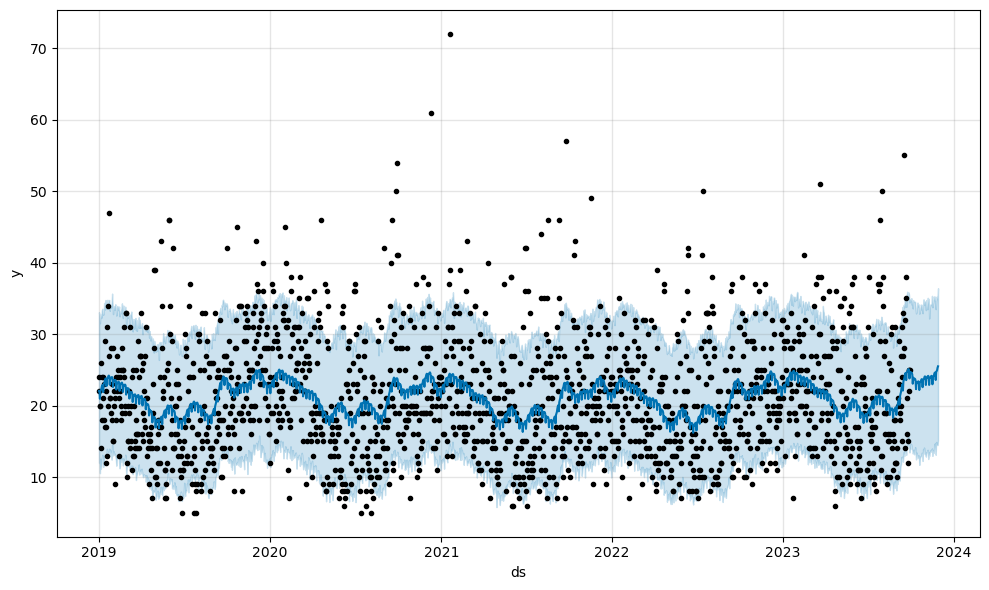

In [100]:
from prophet import Prophet

df_p = df.reset_index()[["time_index", "wind_speed_km"]].rename(
    columns={'time_index':'ds', 'wind_speed_km':'y'}
)

model = Prophet()
model.fit(df_p)

# create dates to predict
future_dates = model.make_future_dataframe(periods=nobs)

# make predictions
pred = model.predict(future_dates)

model.plot(pred)
plt.show()

  0%|          | 0/44 [00:00<?, ?it/s]

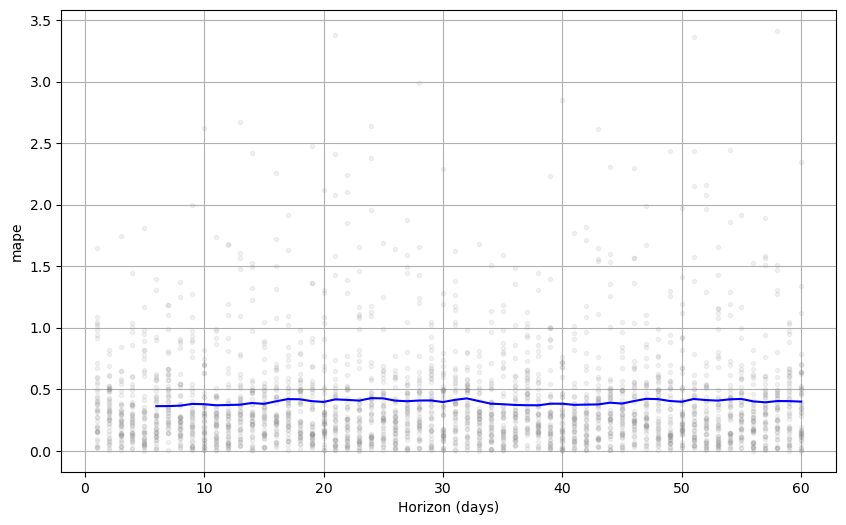

In [101]:
import logging
logging.getLogger('cmdstanpy').setLevel(logging.WARNING) 

from prophet.diagnostics import cross_validation, performance_metrics
from prophet.plot import plot_cross_validation_metric

# Perform cross-validation with initial 365 days for the first training data and the cut-off for every 60 days.
# horizon: forecast horizon
# normally, 
# size of the initial training period (initial) = 3x horizon
# cutoff dates (period) = 1/2 horizon
df_cv = cross_validation(model, initial='366 days', period='30 days', horizon = '60 days')

#res = performance_metrics(df_cv)

#choose between 'mse', 'rmse', 'mae', 'mape', 'coverage'
plot_cross_validation_metric(df_cv, metric='mape')
plt.show()

The prediction error was vary following the days, and it could achieve more than 50% error at many points. This way, it is necessary to tweak the model further to fix the error.

In [102]:
# MAE, RMSE and MAPEE for the Cross-Validation
#mean absolute error
mae = performance_metrics(df_cv)["mae"].mean()

#root mean square error
rmse = performance_metrics(df_cv)["rmse"].mean()

#mean absolute percentage error
mape = performance_metrics(df_cv)["mape"].mean() * 100

print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"MAPE: {mape:.2f}%")

MAE: 6.82
RMSE: 8.66
MAPE: 39.62%


In [107]:
performance_metrics(df_cv)

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,6 days,76.729941,8.759563,6.910285,0.361354,0.284672,0.326729,0.780303
1,7 days,84.985697,9.218769,7.021667,0.361993,0.291049,0.328980,0.799242
2,8 days,81.623451,9.034570,6.876221,0.368399,0.282262,0.326552,0.810606
3,9 days,81.553768,9.030712,6.927691,0.383648,0.284395,0.332819,0.799242
4,10 days,78.760920,8.874735,6.717133,0.379400,0.275681,0.324972,0.803030
5,11 days,77.872678,8.824550,6.735836,0.372268,0.274527,0.322139,0.795455
6,12 days,75.332138,8.679409,6.658591,0.377346,0.272159,0.321552,0.799242
7,13 days,64.899173,8.056002,6.433067,0.386112,0.255756,0.318703,0.795455
8,14 days,73.666309,8.582908,6.735492,0.402293,0.272159,0.330721,0.780303
9,15 days,79.716090,8.928387,6.953267,0.393368,0.277657,0.333252,0.765152


To evaluate the forecasting accuracy of ARIMA and Prophet models, we use three performance metrics: mean absolute error, root mean square error, and mean absolute percentage error. A lower value indicates better accuracy.

In this comparison, both models perform relatively well, with the Prophet model showing slightly better performance in terms of MAE, RMSE. 

The Prophet model would be chosen to make the parameter tuning because it allows to tune more parameters than the ARIMA model.

## Step 5: Parameter tuning in Prophet

There are four main parameters in a Propheet model that could be tuned:
- Seasonality modee
- Seasonality
- Holidays
- Change point prior scale

In [103]:
from sklearn.model_selection import ParameterGrid
import itertools

param_grid = {'seasonality_mode': ["additive", 'multiplicative'],
              'seasonality_prior_scale': [0.01, 0.1, 1.0, 10.0],
              'holidays_prior_scale': [0.01, 0.1, 1.0, 10.0],
              'changepoint_prior_scale': [0.001, 0.01, 0.1, 0.5]}
# Generate all combinations of parameters
# <=> [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
#grid = ParameterGrid(param_grid)
grid = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]

In [104]:
import logging
# Configure logging to show only WARNING level and above
logging.basicConfig(level=logging.ERROR)

# Create a logger for cmdstanpy
logging.getLogger('cmdstanpy').setLevel(logging.ERROR) 

rmse = []
mae = []
mape = []

## a loop with 3 steps: 
## 1. build model using a unique set of parameters, 
## 2. perform cross-validation and store the error,
## 3. repeat
for params in grid:
    m = Prophet(**params).fit(df_p)
    
    df_cv = cross_validation(m,
                            horizon='60 days',
                            period = '30 days',
                            initial= '366 days',
                            parallel= 'processes' # if problems aren't too big <=> parallel cross validation is done on a singlel machine.
                             # for large problems, using a Dask cluster
                            )
    #Measure the error and store the result
    df_m = performance_metrics(df_cv, rolling_window=1)
    rmse.append(df_m['rmse'].values[0])
    mae.append(df_m['mae'].values[0])
    mape.append(df_m['mape'].values[0])
    
#Check the results
tuning_results = pd.DataFrame(grid)
tuning_results['rmse'] = rmse
tuning_results['mae'] = mae
tuning_results['mape'] = mape

best_params = tuning_results[tuning_results.rmse == tuning_results.rmse.min()].transpose()
best_params    

16:44:41 - cmdstanpy - INFO - Chain [1] start processing
16:44:41 - cmdstanpy - INFO - Chain [1] start processing
16:44:41 - cmdstanpy - INFO - Chain [1] start processing
16:44:41 - cmdstanpy - INFO - Chain [1] start processing
16:44:41 - cmdstanpy - INFO - Chain [1] start processing
16:44:41 - cmdstanpy - INFO - Chain [1] start processing
16:44:41 - cmdstanpy - INFO - Chain [1] start processing
16:44:41 - cmdstanpy - INFO - Chain [1] start processing
16:44:41 - cmdstanpy - INFO - Chain [1] start processing
16:44:41 - cmdstanpy - INFO - Chain [1] done processing
16:44:41 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
16:44:41 - cmdstanpy - INFO - Chain [1] start processing
16:44:41 - cmdstanpy - INFO - Chain [1] done processing
16:44:41 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
16:44:

16:44:48 - cmdstanpy - INFO - Chain [1] start processing
16:44:48 - cmdstanpy - INFO - Chain [1] start processing
16:44:48 - cmdstanpy - INFO - Chain [1] done processing
16:44:48 - cmdstanpy - INFO - Chain [1] done processing
16:44:48 - cmdstanpy - INFO - Chain [1] start processing
16:44:48 - cmdstanpy - INFO - Chain [1] done processing
16:44:48 - cmdstanpy - INFO - Chain [1] start processing
16:44:48 - cmdstanpy - INFO - Chain [1] done processing
16:44:48 - cmdstanpy - INFO - Chain [1] start processing
16:44:48 - cmdstanpy - INFO - Chain [1] start processing
16:44:48 - cmdstanpy - INFO - Chain [1] done processing
16:44:48 - cmdstanpy - INFO - Chain [1] done processing
16:44:48 - cmdstanpy - INFO - Chain [1] start processing
16:44:48 - cmdstanpy - INFO - Chain [1] done processing
16:44:48 - cmdstanpy - INFO - Chain [1] start processing
16:44:48 - cmdstanpy - INFO - Chain [1] start processing
16:44:48 - cmdstanpy - INFO - Chain [1] done processing
16:44:48 - cmdstanpy - INFO - Chain [1]

16:44:59 - cmdstanpy - INFO - Chain [1] start processing
16:44:59 - cmdstanpy - INFO - Chain [1] start processing
16:44:59 - cmdstanpy - INFO - Chain [1] done processing
16:44:59 - cmdstanpy - INFO - Chain [1] done processing
16:44:59 - cmdstanpy - INFO - Chain [1] done processing
16:44:59 - cmdstanpy - INFO - Chain [1] done processing
16:44:59 - cmdstanpy - INFO - Chain [1] done processing
16:44:59 - cmdstanpy - INFO - Chain [1] done processing
16:44:59 - cmdstanpy - INFO - Chain [1] start processing
16:44:59 - cmdstanpy - INFO - Chain [1] done processing
16:44:59 - cmdstanpy - INFO - Chain [1] done processing
16:44:59 - cmdstanpy - INFO - Chain [1] start processing
16:44:59 - cmdstanpy - INFO - Chain [1] start processing
16:44:59 - cmdstanpy - INFO - Chain [1] done processing
16:44:59 - cmdstanpy - INFO - Chain [1] start processing
16:44:59 - cmdstanpy - INFO - Chain [1] start processing
16:44:59 - cmdstanpy - INFO - Chain [1] start processing
16:44:59 - cmdstanpy - INFO - Chain [1] 

16:45:07 - cmdstanpy - INFO - Chain [1] start processing
16:45:07 - cmdstanpy - INFO - Chain [1] start processing
16:45:07 - cmdstanpy - INFO - Chain [1] start processing
16:45:07 - cmdstanpy - INFO - Chain [1] start processing
16:45:07 - cmdstanpy - INFO - Chain [1] start processing
16:45:07 - cmdstanpy - INFO - Chain [1] done processing
16:45:07 - cmdstanpy - INFO - Chain [1] done processing
16:45:07 - cmdstanpy - INFO - Chain [1] done processing
16:45:07 - cmdstanpy - INFO - Chain [1] start processing
16:45:07 - cmdstanpy - INFO - Chain [1] done processing
16:45:07 - cmdstanpy - INFO - Chain [1] done processing
16:45:07 - cmdstanpy - INFO - Chain [1] done processing
16:45:07 - cmdstanpy - INFO - Chain [1] start processing
16:45:07 - cmdstanpy - INFO - Chain [1] start processing
16:45:07 - cmdstanpy - INFO - Chain [1] start processing
16:45:07 - cmdstanpy - INFO - Chain [1] done processing
16:45:07 - cmdstanpy - INFO - Chain [1] start processing
16:45:07 - cmdstanpy - INFO - Chain [1

16:45:18 - cmdstanpy - INFO - Chain [1] start processing
16:45:18 - cmdstanpy - INFO - Chain [1] done processing
16:45:18 - cmdstanpy - INFO - Chain [1] start processing
16:45:18 - cmdstanpy - INFO - Chain [1] done processing
16:45:18 - cmdstanpy - INFO - Chain [1] done processing
16:45:18 - cmdstanpy - INFO - Chain [1] done processing
16:45:18 - cmdstanpy - INFO - Chain [1] start processing
16:45:18 - cmdstanpy - INFO - Chain [1] start processing
16:45:18 - cmdstanpy - INFO - Chain [1] start processing
16:45:18 - cmdstanpy - INFO - Chain [1] done processing
16:45:18 - cmdstanpy - INFO - Chain [1] start processing
16:45:18 - cmdstanpy - INFO - Chain [1] start processing
16:45:18 - cmdstanpy - INFO - Chain [1] start processing
16:45:18 - cmdstanpy - INFO - Chain [1] done processing
16:45:18 - cmdstanpy - INFO - Chain [1] start processing
16:45:18 - cmdstanpy - INFO - Chain [1] start processing
16:45:18 - cmdstanpy - INFO - Chain [1] done processing
16:45:18 - cmdstanpy - INFO - Chain [1

16:45:26 - cmdstanpy - INFO - Chain [1] start processing
16:45:26 - cmdstanpy - INFO - Chain [1] done processing
16:45:26 - cmdstanpy - INFO - Chain [1] start processing
16:45:26 - cmdstanpy - INFO - Chain [1] done processing
16:45:26 - cmdstanpy - INFO - Chain [1] start processing
16:45:26 - cmdstanpy - INFO - Chain [1] start processing
16:45:27 - cmdstanpy - INFO - Chain [1] done processing
16:45:27 - cmdstanpy - INFO - Chain [1] done processing
16:45:27 - cmdstanpy - INFO - Chain [1] done processing
16:45:27 - cmdstanpy - INFO - Chain [1] done processing
16:45:27 - cmdstanpy - INFO - Chain [1] done processing
16:45:27 - cmdstanpy - INFO - Chain [1] done processing
16:45:27 - cmdstanpy - INFO - Chain [1] done processing
16:45:30 - cmdstanpy - INFO - Chain [1] start processing
16:45:30 - cmdstanpy - INFO - Chain [1] start processing
16:45:30 - cmdstanpy - INFO - Chain [1] start processing
16:45:30 - cmdstanpy - INFO - Chain [1] start processing
16:45:30 - cmdstanpy - INFO - Chain [1] 

16:45:37 - cmdstanpy - INFO - Chain [1] done processing
16:45:37 - cmdstanpy - INFO - Chain [1] start processing
16:45:37 - cmdstanpy - INFO - Chain [1] done processing
16:45:37 - cmdstanpy - INFO - Chain [1] start processing
16:45:37 - cmdstanpy - INFO - Chain [1] start processing
16:45:37 - cmdstanpy - INFO - Chain [1] start processing
16:45:37 - cmdstanpy - INFO - Chain [1] done processing
16:45:37 - cmdstanpy - INFO - Chain [1] start processing
16:45:37 - cmdstanpy - INFO - Chain [1] start processing
16:45:37 - cmdstanpy - INFO - Chain [1] done processing
16:45:37 - cmdstanpy - INFO - Chain [1] start processing
16:45:37 - cmdstanpy - INFO - Chain [1] done processing
16:45:37 - cmdstanpy - INFO - Chain [1] start processing
16:45:37 - cmdstanpy - INFO - Chain [1] done processing
16:45:37 - cmdstanpy - INFO - Chain [1] done processing
16:45:37 - cmdstanpy - INFO - Chain [1] start processing
16:45:37 - cmdstanpy - INFO - Chain [1] start processing
16:45:37 - cmdstanpy - INFO - Chain [1

16:45:46 - cmdstanpy - INFO - Chain [1] done processing
16:45:46 - cmdstanpy - INFO - Chain [1] done processing
16:45:46 - cmdstanpy - INFO - Chain [1] start processing
16:45:46 - cmdstanpy - INFO - Chain [1] done processing
16:45:46 - cmdstanpy - INFO - Chain [1] done processing
16:45:46 - cmdstanpy - INFO - Chain [1] start processing
16:45:46 - cmdstanpy - INFO - Chain [1] start processing
16:45:46 - cmdstanpy - INFO - Chain [1] done processing
16:45:46 - cmdstanpy - INFO - Chain [1] start processing
16:45:46 - cmdstanpy - INFO - Chain [1] start processing
16:45:47 - cmdstanpy - INFO - Chain [1] done processing
16:45:47 - cmdstanpy - INFO - Chain [1] done processing
16:45:47 - cmdstanpy - INFO - Chain [1] done processing
16:45:47 - cmdstanpy - INFO - Chain [1] done processing
16:45:51 - cmdstanpy - INFO - Chain [1] start processing
16:45:51 - cmdstanpy - INFO - Chain [1] start processing
16:45:51 - cmdstanpy - INFO - Chain [1] done processing
16:45:51 - cmdstanpy - INFO - Chain [1] s

16:45:59 - cmdstanpy - INFO - Chain [1] start processing
16:45:59 - cmdstanpy - INFO - Chain [1] done processing
16:45:59 - cmdstanpy - INFO - Chain [1] done processing
16:45:59 - cmdstanpy - INFO - Chain [1] start processing
16:45:59 - cmdstanpy - INFO - Chain [1] done processing
16:45:59 - cmdstanpy - INFO - Chain [1] start processing
16:45:59 - cmdstanpy - INFO - Chain [1] done processing
16:45:59 - cmdstanpy - INFO - Chain [1] start processing
16:45:59 - cmdstanpy - INFO - Chain [1] done processing
16:45:59 - cmdstanpy - INFO - Chain [1] start processing
16:46:00 - cmdstanpy - INFO - Chain [1] start processing
16:46:00 - cmdstanpy - INFO - Chain [1] start processing
16:46:00 - cmdstanpy - INFO - Chain [1] done processing
16:46:00 - cmdstanpy - INFO - Chain [1] start processing
16:46:00 - cmdstanpy - INFO - Chain [1] done processing
16:46:00 - cmdstanpy - INFO - Chain [1] done processing
16:46:00 - cmdstanpy - INFO - Chain [1] done processing
16:46:00 - cmdstanpy - INFO - Chain [1] 

16:46:07 - cmdstanpy - INFO - Chain [1] start processing
16:46:07 - cmdstanpy - INFO - Chain [1] done processing
16:46:07 - cmdstanpy - INFO - Chain [1] done processing
16:46:07 - cmdstanpy - INFO - Chain [1] start processing
16:46:07 - cmdstanpy - INFO - Chain [1] done processing
16:46:07 - cmdstanpy - INFO - Chain [1] done processing
16:46:07 - cmdstanpy - INFO - Chain [1] done processing
16:46:07 - cmdstanpy - INFO - Chain [1] done processing
16:46:07 - cmdstanpy - INFO - Chain [1] done processing
16:46:07 - cmdstanpy - INFO - Chain [1] done processing
16:46:07 - cmdstanpy - INFO - Chain [1] done processing
16:46:12 - cmdstanpy - INFO - Chain [1] start processing
16:46:12 - cmdstanpy - INFO - Chain [1] start processing
16:46:12 - cmdstanpy - INFO - Chain [1] start processing
16:46:12 - cmdstanpy - INFO - Chain [1] done processing
16:46:12 - cmdstanpy - INFO - Chain [1] start processing
16:46:12 - cmdstanpy - INFO - Chain [1] done processing
16:46:12 - cmdstanpy - INFO - Chain [1] st

16:46:19 - cmdstanpy - INFO - Chain [1] start processing
16:46:19 - cmdstanpy - INFO - Chain [1] start processing
16:46:19 - cmdstanpy - INFO - Chain [1] start processing
16:46:19 - cmdstanpy - INFO - Chain [1] done processing
16:46:19 - cmdstanpy - INFO - Chain [1] start processing
16:46:19 - cmdstanpy - INFO - Chain [1] start processing
16:46:19 - cmdstanpy - INFO - Chain [1] done processing
16:46:19 - cmdstanpy - INFO - Chain [1] done processing
16:46:19 - cmdstanpy - INFO - Chain [1] done processing
16:46:19 - cmdstanpy - INFO - Chain [1] start processing
16:46:19 - cmdstanpy - INFO - Chain [1] start processing
16:46:19 - cmdstanpy - INFO - Chain [1] start processing
16:46:20 - cmdstanpy - INFO - Chain [1] start processing
16:46:20 - cmdstanpy - INFO - Chain [1] start processing
16:46:20 - cmdstanpy - INFO - Chain [1] start processing
16:46:20 - cmdstanpy - INFO - Chain [1] done processing
16:46:20 - cmdstanpy - INFO - Chain [1] done processing
16:46:20 - cmdstanpy - INFO - Chain [

16:46:27 - cmdstanpy - INFO - Chain [1] done processing
16:46:27 - cmdstanpy - INFO - Chain [1] done processing
16:46:27 - cmdstanpy - INFO - Chain [1] done processing
16:46:28 - cmdstanpy - INFO - Chain [1] done processing
16:46:31 - cmdstanpy - INFO - Chain [1] start processing
16:46:31 - cmdstanpy - INFO - Chain [1] start processing
16:46:31 - cmdstanpy - INFO - Chain [1] start processing
16:46:31 - cmdstanpy - INFO - Chain [1] done processing
16:46:31 - cmdstanpy - INFO - Chain [1] done processing
16:46:31 - cmdstanpy - INFO - Chain [1] done processing
16:46:31 - cmdstanpy - INFO - Chain [1] start processing
16:46:31 - cmdstanpy - INFO - Chain [1] start processing
16:46:31 - cmdstanpy - INFO - Chain [1] start processing
16:46:31 - cmdstanpy - INFO - Chain [1] done processing
16:46:31 - cmdstanpy - INFO - Chain [1] done processing
16:46:31 - cmdstanpy - INFO - Chain [1] start processing
16:46:31 - cmdstanpy - INFO - Chain [1] done processing
16:46:31 - cmdstanpy - INFO - Chain [1] s

16:46:38 - cmdstanpy - INFO - Chain [1] start processing
16:46:38 - cmdstanpy - INFO - Chain [1] done processing
16:46:38 - cmdstanpy - INFO - Chain [1] start processing
16:46:38 - cmdstanpy - INFO - Chain [1] start processing
16:46:38 - cmdstanpy - INFO - Chain [1] start processing
16:46:38 - cmdstanpy - INFO - Chain [1] start processing
16:46:38 - cmdstanpy - INFO - Chain [1] start processing
16:46:38 - cmdstanpy - INFO - Chain [1] start processing
16:46:38 - cmdstanpy - INFO - Chain [1] done processing
16:46:38 - cmdstanpy - INFO - Chain [1] done processing
16:46:38 - cmdstanpy - INFO - Chain [1] done processing
16:46:38 - cmdstanpy - INFO - Chain [1] done processing
16:46:38 - cmdstanpy - INFO - Chain [1] start processing
16:46:38 - cmdstanpy - INFO - Chain [1] done processing
16:46:38 - cmdstanpy - INFO - Chain [1] done processing
16:46:38 - cmdstanpy - INFO - Chain [1] start processing
16:46:39 - cmdstanpy - INFO - Chain [1] start processing
16:46:39 - cmdstanpy - INFO - Chain [1

16:46:50 - cmdstanpy - INFO - Chain [1] start processing
16:46:50 - cmdstanpy - INFO - Chain [1] done processing
16:46:50 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
16:46:50 - cmdstanpy - INFO - Chain [1] start processing
16:46:50 - cmdstanpy - INFO - Chain [1] done processing
16:46:50 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
16:46:50 - cmdstanpy - INFO - Chain [1] start processing
16:46:50 - cmdstanpy - INFO - Chain [1] done processing
16:46:50 - cmdstanpy - INFO - Chain [1] start processing
16:46:50 - cmdstanpy - INFO - Chain [1] done processing
16:46:50 - cmdstanpy - INFO - Chain [1] start processing
16:46:50 - cmdstanpy - INFO - Chain [1] done processing
16:46:50 - cmdstanpy - INFO - Chain [1] start processing
16:46:50 - cmdstanpy - INFO - Chain [1] start processing
16:46:50 

16:46:57 - cmdstanpy - INFO - Chain [1] start processing
16:46:57 - cmdstanpy - INFO - Chain [1] done processing
16:46:57 - cmdstanpy - INFO - Chain [1] done processing
16:46:57 - cmdstanpy - INFO - Chain [1] done processing
16:46:57 - cmdstanpy - INFO - Chain [1] done processing
16:46:57 - cmdstanpy - INFO - Chain [1] start processing
16:46:57 - cmdstanpy - INFO - Chain [1] done processing
16:46:57 - cmdstanpy - INFO - Chain [1] start processing
16:46:57 - cmdstanpy - INFO - Chain [1] start processing
16:46:58 - cmdstanpy - INFO - Chain [1] start processing
16:46:58 - cmdstanpy - INFO - Chain [1] done processing
16:46:58 - cmdstanpy - INFO - Chain [1] start processing
16:46:58 - cmdstanpy - INFO - Chain [1] done processing
16:46:58 - cmdstanpy - INFO - Chain [1] start processing
16:46:58 - cmdstanpy - INFO - Chain [1] start processing
16:46:58 - cmdstanpy - INFO - Chain [1] done processing
16:46:58 - cmdstanpy - INFO - Chain [1] done processing
16:46:58 - cmdstanpy - INFO - Chain [1] 

16:47:08 - cmdstanpy - INFO - Chain [1] start processing
16:47:08 - cmdstanpy - INFO - Chain [1] start processing
16:47:08 - cmdstanpy - INFO - Chain [1] done processing
16:47:08 - cmdstanpy - INFO - Chain [1] start processing
16:47:08 - cmdstanpy - INFO - Chain [1] start processing
16:47:08 - cmdstanpy - INFO - Chain [1] start processing
16:47:08 - cmdstanpy - INFO - Chain [1] start processing
16:47:08 - cmdstanpy - INFO - Chain [1] start processing
16:47:08 - cmdstanpy - INFO - Chain [1] start processing
16:47:08 - cmdstanpy - INFO - Chain [1] done processing
16:47:08 - cmdstanpy - INFO - Chain [1] start processing
16:47:08 - cmdstanpy - INFO - Chain [1] start processing
16:47:08 - cmdstanpy - INFO - Chain [1] start processing
16:47:09 - cmdstanpy - INFO - Chain [1] done processing
16:47:09 - cmdstanpy - INFO - Chain [1] start processing
16:47:09 - cmdstanpy - INFO - Chain [1] done processing
16:47:09 - cmdstanpy - INFO - Chain [1] done processing
16:47:09 - cmdstanpy - INFO - Chain 

16:47:16 - cmdstanpy - INFO - Chain [1] done processing
16:47:16 - cmdstanpy - INFO - Chain [1] done processing
16:47:16 - cmdstanpy - INFO - Chain [1] start processing
16:47:16 - cmdstanpy - INFO - Chain [1] done processing
16:47:17 - cmdstanpy - INFO - Chain [1] done processing
16:47:17 - cmdstanpy - INFO - Chain [1] done processing
16:47:17 - cmdstanpy - INFO - Chain [1] done processing
16:47:17 - cmdstanpy - INFO - Chain [1] done processing
16:47:17 - cmdstanpy - INFO - Chain [1] done processing
16:47:17 - cmdstanpy - INFO - Chain [1] done processing
16:47:21 - cmdstanpy - INFO - Chain [1] start processing
16:47:21 - cmdstanpy - INFO - Chain [1] start processing
16:47:21 - cmdstanpy - INFO - Chain [1] start processing
16:47:21 - cmdstanpy - INFO - Chain [1] start processing
16:47:21 - cmdstanpy - INFO - Chain [1] done processing
16:47:21 - cmdstanpy - INFO - Chain [1] done processing
16:47:21 - cmdstanpy - INFO - Chain [1] done processing
16:47:21 - cmdstanpy - INFO - Chain [1] don

16:47:29 - cmdstanpy - INFO - Chain [1] done processing
16:47:29 - cmdstanpy - INFO - Chain [1] done processing
16:47:29 - cmdstanpy - INFO - Chain [1] start processing
16:47:29 - cmdstanpy - INFO - Chain [1] start processing
16:47:29 - cmdstanpy - INFO - Chain [1] done processing
16:47:29 - cmdstanpy - INFO - Chain [1] done processing
16:47:29 - cmdstanpy - INFO - Chain [1] done processing
16:47:29 - cmdstanpy - INFO - Chain [1] done processing
16:47:29 - cmdstanpy - INFO - Chain [1] done processing
16:47:29 - cmdstanpy - INFO - Chain [1] start processing
16:47:29 - cmdstanpy - INFO - Chain [1] done processing
16:47:29 - cmdstanpy - INFO - Chain [1] start processing
16:47:29 - cmdstanpy - INFO - Chain [1] start processing
16:47:29 - cmdstanpy - INFO - Chain [1] start processing
16:47:29 - cmdstanpy - INFO - Chain [1] start processing
16:47:29 - cmdstanpy - INFO - Chain [1] start processing
16:47:29 - cmdstanpy - INFO - Chain [1] done processing
16:47:29 - cmdstanpy - INFO - Chain [1] 

Optimization terminated abnormally. Falling back to Newton.
16:47:42 - cmdstanpy - INFO - Chain [1] start processing
16:47:42 - cmdstanpy - INFO - Chain [1] done processing
16:47:42 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
16:47:42 - cmdstanpy - INFO - Chain [1] start processing
16:47:42 - cmdstanpy - INFO - Chain [1] start processing
16:47:42 - cmdstanpy - INFO - Chain [1] start processing
16:47:42 - cmdstanpy - INFO - Chain [1] start processing
16:47:42 - cmdstanpy - INFO - Chain [1] done processing
16:47:42 - cmdstanpy - INFO - Chain [1] done processing
16:47:42 - cmdstanpy - INFO - Chain [1] start processing
16:47:42 - cmdstanpy - INFO - Chain [1] done processing
16:47:42 - cmdstanpy - INFO - Chain [1] start processing
16:47:42 - cmdstanpy - INFO - Chain [1] start processing
16:47:42 - cmdstanpy - INFO - Chain [1] done processing
16:47:42 - cmdstanpy - INFO - Chain [1] done pro

16:47:51 - cmdstanpy - INFO - Chain [1] done processing
16:47:51 - cmdstanpy - INFO - Chain [1] done processing
16:47:51 - cmdstanpy - INFO - Chain [1] start processing
16:47:51 - cmdstanpy - INFO - Chain [1] done processing
16:47:51 - cmdstanpy - INFO - Chain [1] done processing
16:47:51 - cmdstanpy - INFO - Chain [1] done processing
16:47:51 - cmdstanpy - INFO - Chain [1] start processing
16:47:51 - cmdstanpy - INFO - Chain [1] done processing
16:47:51 - cmdstanpy - INFO - Chain [1] done processing
16:47:51 - cmdstanpy - INFO - Chain [1] done processing
16:47:51 - cmdstanpy - INFO - Chain [1] done processing
16:47:51 - cmdstanpy - INFO - Chain [1] done processing
16:47:51 - cmdstanpy - INFO - Chain [1] done processing
16:47:51 - cmdstanpy - INFO - Chain [1] done processing
16:47:51 - cmdstanpy - INFO - Chain [1] start processing
16:47:51 - cmdstanpy - INFO - Chain [1] start processing
16:47:51 - cmdstanpy - INFO - Chain [1] start processing
16:47:51 - cmdstanpy - INFO - Chain [1] sta

16:48:01 - cmdstanpy - INFO - Chain [1] start processing
16:48:01 - cmdstanpy - INFO - Chain [1] done processing
16:48:01 - cmdstanpy - INFO - Chain [1] done processing
16:48:01 - cmdstanpy - INFO - Chain [1] done processing
16:48:01 - cmdstanpy - INFO - Chain [1] done processing
16:48:01 - cmdstanpy - INFO - Chain [1] done processing
16:48:01 - cmdstanpy - INFO - Chain [1] done processing
16:48:01 - cmdstanpy - INFO - Chain [1] done processing
16:48:01 - cmdstanpy - INFO - Chain [1] start processing
16:48:01 - cmdstanpy - INFO - Chain [1] start processing
16:48:01 - cmdstanpy - INFO - Chain [1] start processing
16:48:01 - cmdstanpy - INFO - Chain [1] start processing
16:48:01 - cmdstanpy - INFO - Chain [1] start processing
16:48:01 - cmdstanpy - INFO - Chain [1] start processing
16:48:01 - cmdstanpy - INFO - Chain [1] start processing
16:48:02 - cmdstanpy - INFO - Chain [1] start processing
16:48:02 - cmdstanpy - INFO - Chain [1] done processing
16:48:02 - cmdstanpy - INFO - Chain [1]

16:48:09 - cmdstanpy - INFO - Chain [1] done processing
16:48:09 - cmdstanpy - INFO - Chain [1] done processing
16:48:09 - cmdstanpy - INFO - Chain [1] done processing
16:48:09 - cmdstanpy - INFO - Chain [1] done processing
16:48:09 - cmdstanpy - INFO - Chain [1] start processing
16:48:09 - cmdstanpy - INFO - Chain [1] done processing
16:48:10 - cmdstanpy - INFO - Chain [1] done processing
16:48:10 - cmdstanpy - INFO - Chain [1] done processing
16:48:23 - cmdstanpy - INFO - Chain [1] done processing
16:48:28 - cmdstanpy - INFO - Chain [1] start processing
16:48:28 - cmdstanpy - INFO - Chain [1] start processing
16:48:28 - cmdstanpy - INFO - Chain [1] start processing
16:48:28 - cmdstanpy - INFO - Chain [1] start processing
16:48:28 - cmdstanpy - INFO - Chain [1] start processing
16:48:28 - cmdstanpy - INFO - Chain [1] done processing
16:48:28 - cmdstanpy - INFO - Chain [1] done processing
16:48:28 - cmdstanpy - INFO - Chain [1] start processing
16:48:28 - cmdstanpy - INFO - Chain [1] s

16:48:37 - cmdstanpy - INFO - Chain [1] start processing
16:48:37 - cmdstanpy - INFO - Chain [1] done processing
16:48:37 - cmdstanpy - INFO - Chain [1] start processing
16:48:37 - cmdstanpy - INFO - Chain [1] start processing
16:48:37 - cmdstanpy - INFO - Chain [1] done processing
16:48:37 - cmdstanpy - INFO - Chain [1] done processing
16:48:37 - cmdstanpy - INFO - Chain [1] done processing
16:48:37 - cmdstanpy - INFO - Chain [1] done processing
16:48:37 - cmdstanpy - INFO - Chain [1] done processing
16:48:37 - cmdstanpy - INFO - Chain [1] start processing
16:48:37 - cmdstanpy - INFO - Chain [1] start processing
16:48:37 - cmdstanpy - INFO - Chain [1] start processing
16:48:37 - cmdstanpy - INFO - Chain [1] start processing
16:48:37 - cmdstanpy - INFO - Chain [1] start processing
16:48:37 - cmdstanpy - INFO - Chain [1] done processing
16:48:37 - cmdstanpy - INFO - Chain [1] start processing
16:48:37 - cmdstanpy - INFO - Chain [1] start processing
16:48:37 - cmdstanpy - INFO - Chain [1

16:48:48 - cmdstanpy - INFO - Chain [1] done processing
16:48:48 - cmdstanpy - INFO - Chain [1] start processing
16:48:48 - cmdstanpy - INFO - Chain [1] start processing
16:48:48 - cmdstanpy - INFO - Chain [1] start processing
16:48:48 - cmdstanpy - INFO - Chain [1] start processing
16:48:48 - cmdstanpy - INFO - Chain [1] done processing
16:48:48 - cmdstanpy - INFO - Chain [1] done processing
16:48:48 - cmdstanpy - INFO - Chain [1] start processing
16:48:48 - cmdstanpy - INFO - Chain [1] start processing
16:48:48 - cmdstanpy - INFO - Chain [1] done processing
16:48:48 - cmdstanpy - INFO - Chain [1] start processing
16:48:48 - cmdstanpy - INFO - Chain [1] done processing
16:48:48 - cmdstanpy - INFO - Chain [1] start processing
16:48:48 - cmdstanpy - INFO - Chain [1] done processing
16:48:48 - cmdstanpy - INFO - Chain [1] done processing
16:48:48 - cmdstanpy - INFO - Chain [1] start processing
16:48:48 - cmdstanpy - INFO - Chain [1] start processing
16:48:48 - cmdstanpy - INFO - Chain [1

16:49:06 - cmdstanpy - INFO - Chain [1] done processing
16:49:06 - cmdstanpy - INFO - Chain [1] start processing
16:49:06 - cmdstanpy - INFO - Chain [1] done processing
16:49:06 - cmdstanpy - INFO - Chain [1] start processing
16:49:06 - cmdstanpy - INFO - Chain [1] start processing
16:49:06 - cmdstanpy - INFO - Chain [1] start processing
16:49:06 - cmdstanpy - INFO - Chain [1] start processing
16:49:06 - cmdstanpy - INFO - Chain [1] start processing
16:49:06 - cmdstanpy - INFO - Chain [1] done processing
16:49:06 - cmdstanpy - INFO - Chain [1] done processing
16:49:06 - cmdstanpy - INFO - Chain [1] done processing
16:49:06 - cmdstanpy - INFO - Chain [1] done processing
16:49:06 - cmdstanpy - INFO - Chain [1] done processing
16:49:06 - cmdstanpy - INFO - Chain [1] done processing
16:49:09 - cmdstanpy - INFO - Chain [1] start processing
16:49:09 - cmdstanpy - INFO - Chain [1] start processing
16:49:09 - cmdstanpy - INFO - Chain [1] start processing
16:49:09 - cmdstanpy - INFO - Chain [1]

16:49:16 - cmdstanpy - INFO - Chain [1] start processing
16:49:16 - cmdstanpy - INFO - Chain [1] done processing
16:49:16 - cmdstanpy - INFO - Chain [1] start processing
16:49:16 - cmdstanpy - INFO - Chain [1] done processing
16:49:16 - cmdstanpy - INFO - Chain [1] done processing
16:49:16 - cmdstanpy - INFO - Chain [1] done processing
16:49:16 - cmdstanpy - INFO - Chain [1] start processing
16:49:16 - cmdstanpy - INFO - Chain [1] start processing
16:49:16 - cmdstanpy - INFO - Chain [1] start processing
16:49:16 - cmdstanpy - INFO - Chain [1] done processing
16:49:16 - cmdstanpy - INFO - Chain [1] start processing
16:49:16 - cmdstanpy - INFO - Chain [1] start processing
16:49:16 - cmdstanpy - INFO - Chain [1] start processing
16:49:16 - cmdstanpy - INFO - Chain [1] start processing
16:49:17 - cmdstanpy - INFO - Chain [1] done processing
16:49:17 - cmdstanpy - INFO - Chain [1] start processing
16:49:17 - cmdstanpy - INFO - Chain [1] done processing
16:49:17 - cmdstanpy - INFO - Chain [1

16:49:24 - cmdstanpy - INFO - Chain [1] done processing
16:49:24 - cmdstanpy - INFO - Chain [1] done processing
16:49:24 - cmdstanpy - INFO - Chain [1] start processing
16:49:24 - cmdstanpy - INFO - Chain [1] done processing
16:49:25 - cmdstanpy - INFO - Chain [1] done processing
16:49:25 - cmdstanpy - INFO - Chain [1] done processing
16:49:36 - cmdstanpy - INFO - Chain [1] done processing
16:49:39 - cmdstanpy - INFO - Chain [1] start processing
16:49:39 - cmdstanpy - INFO - Chain [1] start processing
16:49:39 - cmdstanpy - INFO - Chain [1] start processing
16:49:39 - cmdstanpy - INFO - Chain [1] done processing
16:49:39 - cmdstanpy - INFO - Chain [1] start processing
16:49:39 - cmdstanpy - INFO - Chain [1] start processing
16:49:39 - cmdstanpy - INFO - Chain [1] done processing
16:49:39 - cmdstanpy - INFO - Chain [1] start processing
16:49:40 - cmdstanpy - INFO - Chain [1] start processing
16:49:40 - cmdstanpy - INFO - Chain [1] done processing
16:49:40 - cmdstanpy - INFO - Chain [1] 

16:49:46 - cmdstanpy - INFO - Chain [1] start processing
16:49:46 - cmdstanpy - INFO - Chain [1] done processing
16:49:46 - cmdstanpy - INFO - Chain [1] done processing
16:49:46 - cmdstanpy - INFO - Chain [1] done processing
16:49:46 - cmdstanpy - INFO - Chain [1] done processing
16:49:46 - cmdstanpy - INFO - Chain [1] done processing
16:49:46 - cmdstanpy - INFO - Chain [1] start processing
16:49:46 - cmdstanpy - INFO - Chain [1] done processing
16:49:46 - cmdstanpy - INFO - Chain [1] start processing
16:49:46 - cmdstanpy - INFO - Chain [1] done processing
16:49:46 - cmdstanpy - INFO - Chain [1] start processing
16:49:46 - cmdstanpy - INFO - Chain [1] start processing
16:49:46 - cmdstanpy - INFO - Chain [1] start processing
16:49:46 - cmdstanpy - INFO - Chain [1] start processing
16:49:46 - cmdstanpy - INFO - Chain [1] start processing
16:49:46 - cmdstanpy - INFO - Chain [1] done processing
16:49:46 - cmdstanpy - INFO - Chain [1] start processing
16:49:46 - cmdstanpy - INFO - Chain [1]

16:49:55 - cmdstanpy - INFO - Chain [1] start processing
16:49:55 - cmdstanpy - INFO - Chain [1] start processing
16:49:55 - cmdstanpy - INFO - Chain [1] done processing
16:49:55 - cmdstanpy - INFO - Chain [1] done processing
16:49:55 - cmdstanpy - INFO - Chain [1] start processing
16:49:55 - cmdstanpy - INFO - Chain [1] start processing
16:49:55 - cmdstanpy - INFO - Chain [1] start processing
16:49:55 - cmdstanpy - INFO - Chain [1] done processing
16:49:55 - cmdstanpy - INFO - Chain [1] done processing
16:49:56 - cmdstanpy - INFO - Chain [1] done processing
16:49:56 - cmdstanpy - INFO - Chain [1] start processing
16:49:56 - cmdstanpy - INFO - Chain [1] start processing
16:49:56 - cmdstanpy - INFO - Chain [1] done processing
16:49:56 - cmdstanpy - INFO - Chain [1] start processing
16:49:56 - cmdstanpy - INFO - Chain [1] start processing
16:49:56 - cmdstanpy - INFO - Chain [1] done processing
16:49:56 - cmdstanpy - INFO - Chain [1] start processing
16:49:56 - cmdstanpy - INFO - Chain [1

16:50:15 - cmdstanpy - INFO - Chain [1] done processing
16:50:15 - cmdstanpy - INFO - Chain [1] start processing
16:50:15 - cmdstanpy - INFO - Chain [1] start processing
16:50:15 - cmdstanpy - INFO - Chain [1] done processing
16:50:15 - cmdstanpy - INFO - Chain [1] done processing
16:50:15 - cmdstanpy - INFO - Chain [1] done processing
16:50:15 - cmdstanpy - INFO - Chain [1] done processing
16:50:15 - cmdstanpy - INFO - Chain [1] done processing
16:50:15 - cmdstanpy - INFO - Chain [1] done processing
16:50:19 - cmdstanpy - INFO - Chain [1] start processing
16:50:20 - cmdstanpy - INFO - Chain [1] start processing
16:50:20 - cmdstanpy - INFO - Chain [1] start processing
16:50:20 - cmdstanpy - INFO - Chain [1] start processing
16:50:20 - cmdstanpy - INFO - Chain [1] start processing
16:50:20 - cmdstanpy - INFO - Chain [1] done processing
16:50:20 - cmdstanpy - INFO - Chain [1] start processing
16:50:20 - cmdstanpy - INFO - Chain [1] done processing
16:50:20 - cmdstanpy - INFO - Chain [1] 

16:50:28 - cmdstanpy - INFO - Chain [1] done processing
16:50:28 - cmdstanpy - INFO - Chain [1] start processing
16:50:28 - cmdstanpy - INFO - Chain [1] start processing
16:50:28 - cmdstanpy - INFO - Chain [1] done processing
16:50:28 - cmdstanpy - INFO - Chain [1] done processing
16:50:28 - cmdstanpy - INFO - Chain [1] start processing
16:50:28 - cmdstanpy - INFO - Chain [1] start processing
16:50:28 - cmdstanpy - INFO - Chain [1] done processing
16:50:28 - cmdstanpy - INFO - Chain [1] start processing
16:50:28 - cmdstanpy - INFO - Chain [1] done processing
16:50:28 - cmdstanpy - INFO - Chain [1] done processing
16:50:28 - cmdstanpy - INFO - Chain [1] start processing
16:50:28 - cmdstanpy - INFO - Chain [1] done processing
16:50:28 - cmdstanpy - INFO - Chain [1] start processing
16:50:28 - cmdstanpy - INFO - Chain [1] done processing
16:50:28 - cmdstanpy - INFO - Chain [1] start processing
16:50:28 - cmdstanpy - INFO - Chain [1] done processing
16:50:28 - cmdstanpy - INFO - Chain [1] 

16:50:35 - cmdstanpy - INFO - Chain [1] done processing
16:50:35 - cmdstanpy - INFO - Chain [1] done processing
16:50:36 - cmdstanpy - INFO - Chain [1] done processing
16:50:38 - cmdstanpy - INFO - Chain [1] done processing
16:50:41 - cmdstanpy - INFO - Chain [1] start processing
16:50:41 - cmdstanpy - INFO - Chain [1] start processing
16:50:41 - cmdstanpy - INFO - Chain [1] done processing
16:50:41 - cmdstanpy - INFO - Chain [1] start processing
16:50:41 - cmdstanpy - INFO - Chain [1] done processing
16:50:41 - cmdstanpy - INFO - Chain [1] start processing
16:50:41 - cmdstanpy - INFO - Chain [1] start processing
16:50:41 - cmdstanpy - INFO - Chain [1] start processing
16:50:41 - cmdstanpy - INFO - Chain [1] done processing
16:50:41 - cmdstanpy - INFO - Chain [1] start processing
16:50:41 - cmdstanpy - INFO - Chain [1] done processing
16:50:41 - cmdstanpy - INFO - Chain [1] done processing
16:50:41 - cmdstanpy - INFO - Chain [1] start processing
16:50:41 - cmdstanpy - INFO - Chain [1] 

16:50:47 - cmdstanpy - INFO - Chain [1] start processing
16:50:47 - cmdstanpy - INFO - Chain [1] done processing
16:50:47 - cmdstanpy - INFO - Chain [1] start processing
16:50:47 - cmdstanpy - INFO - Chain [1] done processing
16:50:47 - cmdstanpy - INFO - Chain [1] done processing
16:50:47 - cmdstanpy - INFO - Chain [1] done processing
16:50:47 - cmdstanpy - INFO - Chain [1] done processing
16:50:47 - cmdstanpy - INFO - Chain [1] done processing
16:50:47 - cmdstanpy - INFO - Chain [1] start processing
16:50:47 - cmdstanpy - INFO - Chain [1] done processing
16:50:47 - cmdstanpy - INFO - Chain [1] start processing
16:50:47 - cmdstanpy - INFO - Chain [1] done processing
16:50:47 - cmdstanpy - INFO - Chain [1] done processing
16:50:47 - cmdstanpy - INFO - Chain [1] start processing
16:50:47 - cmdstanpy - INFO - Chain [1] start processing
16:50:47 - cmdstanpy - INFO - Chain [1] start processing
16:50:47 - cmdstanpy - INFO - Chain [1] start processing
16:50:47 - cmdstanpy - INFO - Chain [1] 

16:50:57 - cmdstanpy - INFO - Chain [1] start processing
16:50:57 - cmdstanpy - INFO - Chain [1] done processing
16:50:57 - cmdstanpy - INFO - Chain [1] start processing
16:50:57 - cmdstanpy - INFO - Chain [1] start processing
16:50:57 - cmdstanpy - INFO - Chain [1] done processing
16:50:57 - cmdstanpy - INFO - Chain [1] done processing
16:50:58 - cmdstanpy - INFO - Chain [1] start processing
16:50:58 - cmdstanpy - INFO - Chain [1] start processing
16:50:58 - cmdstanpy - INFO - Chain [1] done processing
16:50:58 - cmdstanpy - INFO - Chain [1] done processing
16:50:58 - cmdstanpy - INFO - Chain [1] start processing
16:50:58 - cmdstanpy - INFO - Chain [1] start processing
16:50:58 - cmdstanpy - INFO - Chain [1] done processing
16:50:58 - cmdstanpy - INFO - Chain [1] done processing
16:50:58 - cmdstanpy - INFO - Chain [1] start processing
16:50:58 - cmdstanpy - INFO - Chain [1] start processing
16:50:58 - cmdstanpy - INFO - Chain [1] done processing
16:50:58 - cmdstanpy - INFO - Chain [1]

16:51:16 - cmdstanpy - INFO - Chain [1] done processing
16:51:16 - cmdstanpy - INFO - Chain [1] start processing
16:51:16 - cmdstanpy - INFO - Chain [1] start processing
16:51:16 - cmdstanpy - INFO - Chain [1] start processing
16:51:16 - cmdstanpy - INFO - Chain [1] start processing
16:51:16 - cmdstanpy - INFO - Chain [1] done processing
16:51:16 - cmdstanpy - INFO - Chain [1] done processing
16:51:16 - cmdstanpy - INFO - Chain [1] done processing
16:51:17 - cmdstanpy - INFO - Chain [1] done processing
16:51:17 - cmdstanpy - INFO - Chain [1] done processing
16:51:17 - cmdstanpy - INFO - Chain [1] done processing
16:51:17 - cmdstanpy - INFO - Chain [1] done processing
16:51:22 - cmdstanpy - INFO - Chain [1] start processing
16:51:22 - cmdstanpy - INFO - Chain [1] start processing
16:51:22 - cmdstanpy - INFO - Chain [1] start processing
16:51:22 - cmdstanpy - INFO - Chain [1] start processing
16:51:22 - cmdstanpy - INFO - Chain [1] start processing
16:51:22 - cmdstanpy - INFO - Chain [1]

16:51:32 - cmdstanpy - INFO - Chain [1] start processing
16:51:32 - cmdstanpy - INFO - Chain [1] start processing
16:51:32 - cmdstanpy - INFO - Chain [1] start processing
16:51:32 - cmdstanpy - INFO - Chain [1] start processing
16:51:32 - cmdstanpy - INFO - Chain [1] start processing
16:51:32 - cmdstanpy - INFO - Chain [1] start processing
16:51:32 - cmdstanpy - INFO - Chain [1] start processing
16:51:32 - cmdstanpy - INFO - Chain [1] start processing
16:51:32 - cmdstanpy - INFO - Chain [1] start processing
16:51:32 - cmdstanpy - INFO - Chain [1] start processing
16:51:32 - cmdstanpy - INFO - Chain [1] done processing
16:51:32 - cmdstanpy - INFO - Chain [1] start processing
16:51:32 - cmdstanpy - INFO - Chain [1] start processing
16:51:33 - cmdstanpy - INFO - Chain [1] done processing
16:51:33 - cmdstanpy - INFO - Chain [1] done processing
16:51:33 - cmdstanpy - INFO - Chain [1] done processing
16:51:33 - cmdstanpy - INFO - Chain [1] done processing
16:51:33 - cmdstanpy - INFO - Chain 

16:51:43 - cmdstanpy - INFO - Chain [1] done processing
16:51:43 - cmdstanpy - INFO - Chain [1] start processing
16:51:43 - cmdstanpy - INFO - Chain [1] done processing
16:51:43 - cmdstanpy - INFO - Chain [1] done processing
16:51:43 - cmdstanpy - INFO - Chain [1] done processing
16:51:43 - cmdstanpy - INFO - Chain [1] start processing
16:51:43 - cmdstanpy - INFO - Chain [1] done processing
16:51:44 - cmdstanpy - INFO - Chain [1] done processing
16:51:47 - cmdstanpy - INFO - Chain [1] done processing
16:51:52 - cmdstanpy - INFO - Chain [1] start processing
16:51:52 - cmdstanpy - INFO - Chain [1] start processing
16:51:52 - cmdstanpy - INFO - Chain [1] start processing
16:51:52 - cmdstanpy - INFO - Chain [1] start processing
16:51:52 - cmdstanpy - INFO - Chain [1] done processing
16:51:52 - cmdstanpy - INFO - Chain [1] start processing
16:51:52 - cmdstanpy - INFO - Chain [1] done processing
16:51:52 - cmdstanpy - INFO - Chain [1] done processing
16:51:52 - cmdstanpy - INFO - Chain [1] d

16:51:59 - cmdstanpy - INFO - Chain [1] start processing
16:51:59 - cmdstanpy - INFO - Chain [1] done processing
16:51:59 - cmdstanpy - INFO - Chain [1] done processing
16:51:59 - cmdstanpy - INFO - Chain [1] start processing
16:51:59 - cmdstanpy - INFO - Chain [1] start processing
16:51:59 - cmdstanpy - INFO - Chain [1] start processing
16:51:59 - cmdstanpy - INFO - Chain [1] done processing
16:51:59 - cmdstanpy - INFO - Chain [1] start processing
16:51:59 - cmdstanpy - INFO - Chain [1] start processing
16:51:59 - cmdstanpy - INFO - Chain [1] start processing
16:51:59 - cmdstanpy - INFO - Chain [1] done processing
16:51:59 - cmdstanpy - INFO - Chain [1] done processing
16:51:59 - cmdstanpy - INFO - Chain [1] done processing
16:51:59 - cmdstanpy - INFO - Chain [1] done processing
16:51:59 - cmdstanpy - INFO - Chain [1] done processing
16:52:00 - cmdstanpy - INFO - Chain [1] start processing
16:52:00 - cmdstanpy - INFO - Chain [1] done processing
16:52:00 - cmdstanpy - INFO - Chain [1] 

16:52:17 - cmdstanpy - INFO - Chain [1] start processing
16:52:17 - cmdstanpy - INFO - Chain [1] start processing
16:52:17 - cmdstanpy - INFO - Chain [1] start processing
16:52:17 - cmdstanpy - INFO - Chain [1] start processing
16:52:17 - cmdstanpy - INFO - Chain [1] done processing
16:52:17 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
16:52:17 - cmdstanpy - INFO - Chain [1] done processing
16:52:17 - cmdstanpy - INFO - Chain [1] done processing
16:52:17 - cmdstanpy - INFO - Chain [1] start processing
16:52:17 - cmdstanpy - INFO - Chain [1] done processing
16:52:17 - cmdstanpy - INFO - Chain [1] start processing
16:52:18 - cmdstanpy - INFO - Chain [1] start processing
16:52:18 - cmdstanpy - INFO - Chain [1] start processing
16:52:18 - cmdstanpy - INFO - Chain [1] done processing
16:52:18 - cmdstanpy - INFO - Chain [1] done processing
16:52:18 - cmdstanpy - INFO - Chain [1] start proces

16:52:33 - cmdstanpy - INFO - Chain [1] done processing
16:52:33 - cmdstanpy - INFO - Chain [1] start processing
16:52:33 - cmdstanpy - INFO - Chain [1] done processing
16:52:33 - cmdstanpy - INFO - Chain [1] done processing
16:52:33 - cmdstanpy - INFO - Chain [1] start processing
16:52:33 - cmdstanpy - INFO - Chain [1] done processing
16:52:33 - cmdstanpy - INFO - Chain [1] done processing
16:52:33 - cmdstanpy - INFO - Chain [1] done processing
16:52:33 - cmdstanpy - INFO - Chain [1] start processing
16:52:33 - cmdstanpy - INFO - Chain [1] start processing
16:52:33 - cmdstanpy - INFO - Chain [1] start processing
16:52:33 - cmdstanpy - INFO - Chain [1] done processing
16:52:33 - cmdstanpy - INFO - Chain [1] start processing
16:52:33 - cmdstanpy - INFO - Chain [1] start processing
16:52:34 - cmdstanpy - INFO - Chain [1] done processing
16:52:34 - cmdstanpy - INFO - Chain [1] start processing
16:52:34 - cmdstanpy - INFO - Chain [1] start processing
16:52:34 - cmdstanpy - INFO - Chain [1]

16:52:47 - cmdstanpy - INFO - Chain [1] start processing
16:52:47 - cmdstanpy - INFO - Chain [1] start processing
16:52:47 - cmdstanpy - INFO - Chain [1] start processing
16:52:47 - cmdstanpy - INFO - Chain [1] done processing
16:52:47 - cmdstanpy - INFO - Chain [1] start processing
16:52:47 - cmdstanpy - INFO - Chain [1] done processing
16:52:47 - cmdstanpy - INFO - Chain [1] done processing
16:52:47 - cmdstanpy - INFO - Chain [1] done processing
16:52:47 - cmdstanpy - INFO - Chain [1] done processing
16:52:47 - cmdstanpy - INFO - Chain [1] done processing
16:52:47 - cmdstanpy - INFO - Chain [1] done processing
16:52:47 - cmdstanpy - INFO - Chain [1] done processing
16:52:47 - cmdstanpy - INFO - Chain [1] done processing
16:52:47 - cmdstanpy - INFO - Chain [1] done processing
16:52:47 - cmdstanpy - INFO - Chain [1] start processing
16:52:47 - cmdstanpy - INFO - Chain [1] start processing
16:52:47 - cmdstanpy - INFO - Chain [1] start processing
16:52:47 - cmdstanpy - INFO - Chain [1] s

16:52:57 - cmdstanpy - INFO - Chain [1] done processing
16:52:57 - cmdstanpy - INFO - Chain [1] done processing
16:52:57 - cmdstanpy - INFO - Chain [1] done processing
16:52:57 - cmdstanpy - INFO - Chain [1] done processing
16:52:57 - cmdstanpy - INFO - Chain [1] done processing
16:52:57 - cmdstanpy - INFO - Chain [1] done processing
16:52:57 - cmdstanpy - INFO - Chain [1] start processing
16:52:57 - cmdstanpy - INFO - Chain [1] start processing
16:52:57 - cmdstanpy - INFO - Chain [1] start processing
16:52:57 - cmdstanpy - INFO - Chain [1] start processing
16:52:57 - cmdstanpy - INFO - Chain [1] done processing
16:52:57 - cmdstanpy - INFO - Chain [1] start processing
16:52:57 - cmdstanpy - INFO - Chain [1] done processing
16:52:57 - cmdstanpy - INFO - Chain [1] done processing
16:52:57 - cmdstanpy - INFO - Chain [1] done processing
16:52:57 - cmdstanpy - INFO - Chain [1] done processing
16:52:58 - cmdstanpy - INFO - Chain [1] done processing
16:53:00 - cmdstanpy - INFO - Chain [1] don

16:53:10 - cmdstanpy - INFO - Chain [1] done processing
16:53:10 - cmdstanpy - INFO - Chain [1] done processing
16:53:10 - cmdstanpy - INFO - Chain [1] done processing
16:53:10 - cmdstanpy - INFO - Chain [1] start processing
16:53:10 - cmdstanpy - INFO - Chain [1] start processing
16:53:10 - cmdstanpy - INFO - Chain [1] start processing
16:53:10 - cmdstanpy - INFO - Chain [1] start processing
16:53:10 - cmdstanpy - INFO - Chain [1] start processing
16:53:10 - cmdstanpy - INFO - Chain [1] done processing
16:53:10 - cmdstanpy - INFO - Chain [1] start processing
16:53:10 - cmdstanpy - INFO - Chain [1] start processing
16:53:10 - cmdstanpy - INFO - Chain [1] start processing
16:53:10 - cmdstanpy - INFO - Chain [1] start processing
16:53:10 - cmdstanpy - INFO - Chain [1] done processing
16:53:10 - cmdstanpy - INFO - Chain [1] start processing
16:53:10 - cmdstanpy - INFO - Chain [1] done processing
16:53:10 - cmdstanpy - INFO - Chain [1] done processing
16:53:10 - cmdstanpy - INFO - Chain [1

16:53:25 - cmdstanpy - INFO - Chain [1] start processing
16:53:25 - cmdstanpy - INFO - Chain [1] done processing
16:53:25 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
16:53:25 - cmdstanpy - INFO - Chain [1] start processing
16:53:25 - cmdstanpy - INFO - Chain [1] done processing
16:53:25 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
16:53:25 - cmdstanpy - INFO - Chain [1] start processing
16:53:25 - cmdstanpy - INFO - Chain [1] start processing
16:53:25 - cmdstanpy - INFO - Chain [1] start processing
16:53:25 - cmdstanpy - INFO - Chain [1] start processing
16:53:25 - cmdstanpy - INFO - Chain [1] done processing
16:53:25 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
16:53:25 - cmdstanpy -

16:53:33 - cmdstanpy - INFO - Chain [1] done processing
16:53:33 - cmdstanpy - INFO - Chain [1] start processing
16:53:33 - cmdstanpy - INFO - Chain [1] done processing
16:53:33 - cmdstanpy - INFO - Chain [1] done processing
16:53:33 - cmdstanpy - INFO - Chain [1] done processing
16:53:33 - cmdstanpy - INFO - Chain [1] start processing
16:53:33 - cmdstanpy - INFO - Chain [1] start processing
16:53:33 - cmdstanpy - INFO - Chain [1] start processing
16:53:33 - cmdstanpy - INFO - Chain [1] start processing
16:53:33 - cmdstanpy - INFO - Chain [1] start processing
16:53:33 - cmdstanpy - INFO - Chain [1] done processing
16:53:33 - cmdstanpy - INFO - Chain [1] done processing
16:53:33 - cmdstanpy - INFO - Chain [1] done processing
16:53:34 - cmdstanpy - INFO - Chain [1] start processing
16:53:34 - cmdstanpy - INFO - Chain [1] start processing
16:53:34 - cmdstanpy - INFO - Chain [1] done processing
16:53:34 - cmdstanpy - INFO - Chain [1] start processing
16:53:34 - cmdstanpy - INFO - Chain [1]

16:53:42 - cmdstanpy - INFO - Chain [1] done processing
16:53:42 - cmdstanpy - INFO - Chain [1] start processing
16:53:42 - cmdstanpy - INFO - Chain [1] start processing
16:53:42 - cmdstanpy - INFO - Chain [1] done processing
16:53:42 - cmdstanpy - INFO - Chain [1] start processing
16:53:42 - cmdstanpy - INFO - Chain [1] start processing
16:53:42 - cmdstanpy - INFO - Chain [1] start processing
16:53:43 - cmdstanpy - INFO - Chain [1] start processing
16:53:43 - cmdstanpy - INFO - Chain [1] start processing
16:53:43 - cmdstanpy - INFO - Chain [1] done processing
16:53:43 - cmdstanpy - INFO - Chain [1] done processing
16:53:43 - cmdstanpy - INFO - Chain [1] start processing
16:53:43 - cmdstanpy - INFO - Chain [1] done processing
16:53:43 - cmdstanpy - INFO - Chain [1] start processing
16:53:43 - cmdstanpy - INFO - Chain [1] start processing
16:53:43 - cmdstanpy - INFO - Chain [1] done processing
16:53:43 - cmdstanpy - INFO - Chain [1] done processing
16:53:43 - cmdstanpy - INFO - Chain [1

16:53:50 - cmdstanpy - INFO - Chain [1] start processing
16:53:50 - cmdstanpy - INFO - Chain [1] start processing
16:53:50 - cmdstanpy - INFO - Chain [1] done processing
16:53:50 - cmdstanpy - INFO - Chain [1] done processing
16:53:50 - cmdstanpy - INFO - Chain [1] done processing
16:53:50 - cmdstanpy - INFO - Chain [1] start processing
16:53:50 - cmdstanpy - INFO - Chain [1] start processing
16:53:50 - cmdstanpy - INFO - Chain [1] done processing
16:53:50 - cmdstanpy - INFO - Chain [1] start processing
16:53:50 - cmdstanpy - INFO - Chain [1] done processing
16:53:50 - cmdstanpy - INFO - Chain [1] done processing
16:53:50 - cmdstanpy - INFO - Chain [1] start processing
16:53:50 - cmdstanpy - INFO - Chain [1] done processing
16:53:50 - cmdstanpy - INFO - Chain [1] done processing
16:53:50 - cmdstanpy - INFO - Chain [1] start processing
16:53:50 - cmdstanpy - INFO - Chain [1] start processing
16:53:50 - cmdstanpy - INFO - Chain [1] done processing
16:53:51 - cmdstanpy - INFO - Chain [1] 

16:54:02 - cmdstanpy - INFO - Chain [1] done processing
16:54:03 - cmdstanpy - INFO - Chain [1] done processing
16:54:03 - cmdstanpy - INFO - Chain [1] start processing
16:54:03 - cmdstanpy - INFO - Chain [1] done processing
16:54:03 - cmdstanpy - INFO - Chain [1] start processing
16:54:03 - cmdstanpy - INFO - Chain [1] done processing
16:54:03 - cmdstanpy - INFO - Chain [1] start processing
16:54:03 - cmdstanpy - INFO - Chain [1] done processing
16:54:03 - cmdstanpy - INFO - Chain [1] start processing
16:54:03 - cmdstanpy - INFO - Chain [1] done processing
16:54:03 - cmdstanpy - INFO - Chain [1] done processing
16:54:03 - cmdstanpy - INFO - Chain [1] start processing
16:54:03 - cmdstanpy - INFO - Chain [1] start processing
16:54:03 - cmdstanpy - INFO - Chain [1] start processing
16:54:03 - cmdstanpy - INFO - Chain [1] done processing
16:54:03 - cmdstanpy - INFO - Chain [1] start processing
16:54:03 - cmdstanpy - INFO - Chain [1] done processing
16:54:03 - cmdstanpy - INFO - Chain [1] 

16:54:11 - cmdstanpy - INFO - Chain [1] done processing
16:54:11 - cmdstanpy - INFO - Chain [1] done processing
16:54:15 - cmdstanpy - INFO - Chain [1] start processing
16:54:15 - cmdstanpy - INFO - Chain [1] start processing
16:54:15 - cmdstanpy - INFO - Chain [1] start processing
16:54:15 - cmdstanpy - INFO - Chain [1] done processing
16:54:15 - cmdstanpy - INFO - Chain [1] done processing
16:54:15 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
16:54:15 - cmdstanpy - INFO - Chain [1] start processing
16:54:15 - cmdstanpy - INFO - Chain [1] start processing
16:54:15 - cmdstanpy - INFO - Chain [1] done processing
16:54:15 - cmdstanpy - INFO - Chain [1] start processing
16:54:15 - cmdstanpy - INFO - Chain [1] done processing
16:54:15 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
16:54:15 -

16:54:23 - cmdstanpy - INFO - Chain [1] done processing
16:54:23 - cmdstanpy - INFO - Chain [1] start processing
16:54:24 - cmdstanpy - INFO - Chain [1] start processing
16:54:24 - cmdstanpy - INFO - Chain [1] start processing
16:54:24 - cmdstanpy - INFO - Chain [1] done processing
16:54:24 - cmdstanpy - INFO - Chain [1] done processing
16:54:24 - cmdstanpy - INFO - Chain [1] start processing
16:54:24 - cmdstanpy - INFO - Chain [1] done processing
16:54:24 - cmdstanpy - INFO - Chain [1] done processing
16:54:24 - cmdstanpy - INFO - Chain [1] done processing
16:54:24 - cmdstanpy - INFO - Chain [1] start processing
16:54:24 - cmdstanpy - INFO - Chain [1] start processing
16:54:24 - cmdstanpy - INFO - Chain [1] start processing
16:54:24 - cmdstanpy - INFO - Chain [1] done processing
16:54:24 - cmdstanpy - INFO - Chain [1] start processing
16:54:24 - cmdstanpy - INFO - Chain [1] done processing
16:54:24 - cmdstanpy - INFO - Chain [1] start processing
16:54:24 - cmdstanpy - INFO - Chain [1]

16:54:33 - cmdstanpy - INFO - Chain [1] start processing
16:54:33 - cmdstanpy - INFO - Chain [1] start processing
16:54:33 - cmdstanpy - INFO - Chain [1] start processing
16:54:33 - cmdstanpy - INFO - Chain [1] done processing
16:54:33 - cmdstanpy - INFO - Chain [1] start processing
16:54:33 - cmdstanpy - INFO - Chain [1] start processing
16:54:33 - cmdstanpy - INFO - Chain [1] done processing
16:54:33 - cmdstanpy - INFO - Chain [1] start processing
16:54:33 - cmdstanpy - INFO - Chain [1] start processing
16:54:33 - cmdstanpy - INFO - Chain [1] start processing
16:54:33 - cmdstanpy - INFO - Chain [1] start processing
16:54:33 - cmdstanpy - INFO - Chain [1] done processing
16:54:33 - cmdstanpy - INFO - Chain [1] start processing
16:54:34 - cmdstanpy - INFO - Chain [1] done processing
16:54:34 - cmdstanpy - INFO - Chain [1] start processing
16:54:34 - cmdstanpy - INFO - Chain [1] done processing
16:54:34 - cmdstanpy - INFO - Chain [1] done processing
16:54:34 - cmdstanpy - INFO - Chain [

16:54:41 - cmdstanpy - INFO - Chain [1] start processing
16:54:41 - cmdstanpy - INFO - Chain [1] start processing
16:54:41 - cmdstanpy - INFO - Chain [1] done processing
16:54:41 - cmdstanpy - INFO - Chain [1] start processing
16:54:41 - cmdstanpy - INFO - Chain [1] start processing
16:54:41 - cmdstanpy - INFO - Chain [1] done processing
16:54:41 - cmdstanpy - INFO - Chain [1] start processing
16:54:41 - cmdstanpy - INFO - Chain [1] done processing
16:54:41 - cmdstanpy - INFO - Chain [1] start processing
16:54:41 - cmdstanpy - INFO - Chain [1] done processing
16:54:41 - cmdstanpy - INFO - Chain [1] done processing
16:54:42 - cmdstanpy - INFO - Chain [1] done processing
16:54:42 - cmdstanpy - INFO - Chain [1] start processing
16:54:42 - cmdstanpy - INFO - Chain [1] start processing
16:54:42 - cmdstanpy - INFO - Chain [1] done processing
16:54:42 - cmdstanpy - INFO - Chain [1] start processing
16:54:42 - cmdstanpy - INFO - Chain [1] start processing
16:54:42 - cmdstanpy - INFO - Chain [1

16:54:52 - cmdstanpy - INFO - Chain [1] start processing
16:54:52 - cmdstanpy - INFO - Chain [1] done processing
16:54:52 - cmdstanpy - INFO - Chain [1] done processing
16:54:52 - cmdstanpy - INFO - Chain [1] done processing
16:54:52 - cmdstanpy - INFO - Chain [1] done processing
16:54:52 - cmdstanpy - INFO - Chain [1] start processing
16:54:52 - cmdstanpy - INFO - Chain [1] start processing
16:54:52 - cmdstanpy - INFO - Chain [1] start processing
16:54:52 - cmdstanpy - INFO - Chain [1] start processing
16:54:52 - cmdstanpy - INFO - Chain [1] start processing
16:54:52 - cmdstanpy - INFO - Chain [1] done processing
16:54:52 - cmdstanpy - INFO - Chain [1] start processing
16:54:52 - cmdstanpy - INFO - Chain [1] done processing
16:54:52 - cmdstanpy - INFO - Chain [1] start processing
16:54:53 - cmdstanpy - INFO - Chain [1] start processing
16:54:53 - cmdstanpy - INFO - Chain [1] done processing
16:54:53 - cmdstanpy - INFO - Chain [1] done processing
16:54:53 - cmdstanpy - INFO - Chain [1]

16:55:00 - cmdstanpy - INFO - Chain [1] done processing
16:55:00 - cmdstanpy - INFO - Chain [1] start processing
16:55:00 - cmdstanpy - INFO - Chain [1] done processing
16:55:00 - cmdstanpy - INFO - Chain [1] done processing
16:55:00 - cmdstanpy - INFO - Chain [1] done processing
16:55:00 - cmdstanpy - INFO - Chain [1] done processing
16:55:00 - cmdstanpy - INFO - Chain [1] done processing
16:55:00 - cmdstanpy - INFO - Chain [1] done processing
16:55:00 - cmdstanpy - INFO - Chain [1] done processing
16:55:00 - cmdstanpy - INFO - Chain [1] done processing
16:55:00 - cmdstanpy - INFO - Chain [1] done processing
16:55:05 - cmdstanpy - INFO - Chain [1] start processing
16:55:05 - cmdstanpy - INFO - Chain [1] start processing
16:55:05 - cmdstanpy - INFO - Chain [1] start processing
16:55:05 - cmdstanpy - INFO - Chain [1] done processing
16:55:05 - cmdstanpy - INFO - Chain [1] start processing
16:55:05 - cmdstanpy - INFO - Chain [1] done processing
16:55:05 - cmdstanpy - ERROR - Chain [1] er

16:55:11 - cmdstanpy - INFO - Chain [1] start processing
16:55:11 - cmdstanpy - INFO - Chain [1] done processing
16:55:11 - cmdstanpy - INFO - Chain [1] done processing
16:55:11 - cmdstanpy - INFO - Chain [1] start processing
16:55:11 - cmdstanpy - INFO - Chain [1] done processing
16:55:11 - cmdstanpy - INFO - Chain [1] start processing
16:55:11 - cmdstanpy - INFO - Chain [1] start processing
16:55:12 - cmdstanpy - INFO - Chain [1] start processing
16:55:12 - cmdstanpy - INFO - Chain [1] done processing
16:55:12 - cmdstanpy - INFO - Chain [1] start processing
16:55:12 - cmdstanpy - INFO - Chain [1] start processing
16:55:12 - cmdstanpy - INFO - Chain [1] done processing
16:55:12 - cmdstanpy - INFO - Chain [1] start processing
16:55:12 - cmdstanpy - INFO - Chain [1] start processing
16:55:12 - cmdstanpy - INFO - Chain [1] done processing
16:55:12 - cmdstanpy - INFO - Chain [1] start processing
16:55:12 - cmdstanpy - INFO - Chain [1] done processing
16:55:12 - cmdstanpy - INFO - Chain [1

16:55:18 - cmdstanpy - INFO - Chain [1] done processing
16:55:18 - cmdstanpy - INFO - Chain [1] done processing
16:55:18 - cmdstanpy - INFO - Chain [1] done processing
16:55:18 - cmdstanpy - INFO - Chain [1] done processing
16:55:21 - cmdstanpy - INFO - Chain [1] start processing
16:55:21 - cmdstanpy - INFO - Chain [1] start processing
16:55:21 - cmdstanpy - INFO - Chain [1] start processing
16:55:21 - cmdstanpy - INFO - Chain [1] start processing
16:55:21 - cmdstanpy - INFO - Chain [1] start processing
16:55:21 - cmdstanpy - INFO - Chain [1] start processing
16:55:21 - cmdstanpy - INFO - Chain [1] start processing
16:55:21 - cmdstanpy - INFO - Chain [1] done processing
16:55:21 - cmdstanpy - INFO - Chain [1] done processing
16:55:21 - cmdstanpy - INFO - Chain [1] done processing
16:55:21 - cmdstanpy - INFO - Chain [1] start processing
16:55:21 - cmdstanpy - INFO - Chain [1] start processing
16:55:21 - cmdstanpy - INFO - Chain [1] start processing
16:55:21 - cmdstanpy - INFO - Chain [1

16:55:28 - cmdstanpy - INFO - Chain [1] done processing
16:55:28 - cmdstanpy - INFO - Chain [1] start processing
16:55:28 - cmdstanpy - INFO - Chain [1] start processing
16:55:28 - cmdstanpy - INFO - Chain [1] done processing
16:55:28 - cmdstanpy - INFO - Chain [1] start processing
16:55:28 - cmdstanpy - INFO - Chain [1] done processing
16:55:28 - cmdstanpy - INFO - Chain [1] start processing
16:55:28 - cmdstanpy - INFO - Chain [1] start processing
16:55:28 - cmdstanpy - INFO - Chain [1] done processing
16:55:28 - cmdstanpy - INFO - Chain [1] done processing
16:55:28 - cmdstanpy - INFO - Chain [1] done processing
16:55:28 - cmdstanpy - INFO - Chain [1] start processing
16:55:28 - cmdstanpy - INFO - Chain [1] done processing
16:55:28 - cmdstanpy - INFO - Chain [1] start processing
16:55:28 - cmdstanpy - INFO - Chain [1] start processing
16:55:28 - cmdstanpy - INFO - Chain [1] done processing
16:55:28 - cmdstanpy - INFO - Chain [1] start processing
16:55:28 - cmdstanpy - INFO - Chain [1]

16:55:39 - cmdstanpy - INFO - Chain [1] done processing
16:55:39 - cmdstanpy - INFO - Chain [1] done processing
16:55:39 - cmdstanpy - INFO - Chain [1] start processing
16:55:39 - cmdstanpy - INFO - Chain [1] done processing
16:55:39 - cmdstanpy - INFO - Chain [1] done processing
16:55:39 - cmdstanpy - INFO - Chain [1] start processing
16:55:39 - cmdstanpy - INFO - Chain [1] done processing
16:55:39 - cmdstanpy - INFO - Chain [1] done processing
16:55:39 - cmdstanpy - INFO - Chain [1] start processing
16:55:39 - cmdstanpy - INFO - Chain [1] done processing
16:55:39 - cmdstanpy - INFO - Chain [1] done processing
16:55:39 - cmdstanpy - INFO - Chain [1] start processing
16:55:39 - cmdstanpy - INFO - Chain [1] start processing
16:55:39 - cmdstanpy - INFO - Chain [1] start processing
16:55:39 - cmdstanpy - INFO - Chain [1] start processing
16:55:39 - cmdstanpy - INFO - Chain [1] done processing
16:55:39 - cmdstanpy - INFO - Chain [1] done processing
16:55:39 - cmdstanpy - INFO - Chain [1] d

16:55:46 - cmdstanpy - INFO - Chain [1] done processing
16:55:46 - cmdstanpy - INFO - Chain [1] done processing
16:55:47 - cmdstanpy - INFO - Chain [1] start processing
16:55:47 - cmdstanpy - INFO - Chain [1] start processing
16:55:47 - cmdstanpy - INFO - Chain [1] done processing
16:55:47 - cmdstanpy - INFO - Chain [1] done processing
16:55:47 - cmdstanpy - INFO - Chain [1] done processing
16:55:47 - cmdstanpy - INFO - Chain [1] done processing
16:55:47 - cmdstanpy - INFO - Chain [1] done processing
16:55:47 - cmdstanpy - INFO - Chain [1] done processing
16:55:47 - cmdstanpy - INFO - Chain [1] done processing
16:55:47 - cmdstanpy - INFO - Chain [1] done processing
16:55:47 - cmdstanpy - INFO - Chain [1] done processing
16:55:50 - cmdstanpy - INFO - Chain [1] start processing
16:55:50 - cmdstanpy - INFO - Chain [1] start processing
16:55:50 - cmdstanpy - INFO - Chain [1] done processing
16:55:50 - cmdstanpy - INFO - Chain [1] start processing
16:55:50 - cmdstanpy - INFO - Chain [1] sta

16:55:57 - cmdstanpy - INFO - Chain [1] start processing
16:55:57 - cmdstanpy - INFO - Chain [1] done processing
16:55:57 - cmdstanpy - INFO - Chain [1] start processing
16:55:57 - cmdstanpy - INFO - Chain [1] done processing
16:55:57 - cmdstanpy - INFO - Chain [1] done processing
16:55:57 - cmdstanpy - INFO - Chain [1] start processing
16:55:57 - cmdstanpy - INFO - Chain [1] start processing
16:55:57 - cmdstanpy - INFO - Chain [1] start processing
16:55:57 - cmdstanpy - INFO - Chain [1] start processing
16:55:57 - cmdstanpy - INFO - Chain [1] start processing
16:55:57 - cmdstanpy - INFO - Chain [1] done processing
16:55:57 - cmdstanpy - INFO - Chain [1] start processing
16:55:57 - cmdstanpy - INFO - Chain [1] done processing
16:55:57 - cmdstanpy - INFO - Chain [1] start processing
16:55:58 - cmdstanpy - INFO - Chain [1] start processing
16:55:58 - cmdstanpy - INFO - Chain [1] done processing
16:55:58 - cmdstanpy - INFO - Chain [1] done processing
16:55:58 - cmdstanpy - INFO - Chain [1

16:56:04 - cmdstanpy - INFO - Chain [1] done processing
16:56:04 - cmdstanpy - INFO - Chain [1] start processing
16:56:04 - cmdstanpy - INFO - Chain [1] done processing
16:56:04 - cmdstanpy - INFO - Chain [1] start processing
16:56:04 - cmdstanpy - INFO - Chain [1] start processing
16:56:04 - cmdstanpy - INFO - Chain [1] start processing
16:56:04 - cmdstanpy - INFO - Chain [1] start processing
16:56:04 - cmdstanpy - INFO - Chain [1] done processing
16:56:04 - cmdstanpy - INFO - Chain [1] done processing
16:56:04 - cmdstanpy - INFO - Chain [1] done processing
16:56:04 - cmdstanpy - INFO - Chain [1] done processing
16:56:04 - cmdstanpy - INFO - Chain [1] done processing
16:56:04 - cmdstanpy - INFO - Chain [1] done processing
16:56:08 - cmdstanpy - INFO - Chain [1] start processing
16:56:08 - cmdstanpy - INFO - Chain [1] start processing
16:56:08 - cmdstanpy - INFO - Chain [1] start processing
16:56:08 - cmdstanpy - INFO - Chain [1] start processing
16:56:08 - cmdstanpy - INFO - Chain [1]

16:56:14 - cmdstanpy - INFO - Chain [1] start processing
16:56:14 - cmdstanpy - INFO - Chain [1] done processing
16:56:14 - cmdstanpy - INFO - Chain [1] done processing
16:56:14 - cmdstanpy - INFO - Chain [1] start processing
16:56:14 - cmdstanpy - INFO - Chain [1] done processing
16:56:14 - cmdstanpy - INFO - Chain [1] start processing
16:56:14 - cmdstanpy - INFO - Chain [1] start processing
16:56:14 - cmdstanpy - INFO - Chain [1] start processing
16:56:14 - cmdstanpy - INFO - Chain [1] done processing
16:56:14 - cmdstanpy - INFO - Chain [1] done processing
16:56:14 - cmdstanpy - INFO - Chain [1] done processing
16:56:14 - cmdstanpy - INFO - Chain [1] start processing
16:56:14 - cmdstanpy - INFO - Chain [1] start processing
16:56:14 - cmdstanpy - INFO - Chain [1] done processing
16:56:14 - cmdstanpy - INFO - Chain [1] done processing
16:56:14 - cmdstanpy - INFO - Chain [1] start processing
16:56:15 - cmdstanpy - INFO - Chain [1] done processing
16:56:15 - cmdstanpy - INFO - Chain [1] 

16:56:22 - cmdstanpy - INFO - Chain [1] done processing
16:56:22 - cmdstanpy - INFO - Chain [1] done processing
16:56:22 - cmdstanpy - INFO - Chain [1] done processing
16:56:22 - cmdstanpy - INFO - Chain [1] done processing
16:56:22 - cmdstanpy - INFO - Chain [1] done processing
16:56:22 - cmdstanpy - INFO - Chain [1] done processing
16:56:25 - cmdstanpy - INFO - Chain [1] start processing
16:56:25 - cmdstanpy - INFO - Chain [1] start processing
16:56:25 - cmdstanpy - INFO - Chain [1] done processing
16:56:25 - cmdstanpy - INFO - Chain [1] done processing
16:56:25 - cmdstanpy - INFO - Chain [1] start processing
16:56:26 - cmdstanpy - INFO - Chain [1] start processing
16:56:26 - cmdstanpy - INFO - Chain [1] start processing
16:56:26 - cmdstanpy - INFO - Chain [1] start processing
16:56:26 - cmdstanpy - INFO - Chain [1] start processing
16:56:26 - cmdstanpy - INFO - Chain [1] done processing
16:56:26 - cmdstanpy - INFO - Chain [1] done processing
16:56:26 - cmdstanpy - INFO - Chain [1] s

16:56:32 - cmdstanpy - INFO - Chain [1] done processing
16:56:32 - cmdstanpy - INFO - Chain [1] done processing
16:56:32 - cmdstanpy - INFO - Chain [1] done processing
16:56:32 - cmdstanpy - INFO - Chain [1] start processing
16:56:32 - cmdstanpy - INFO - Chain [1] start processing
16:56:32 - cmdstanpy - INFO - Chain [1] start processing
16:56:32 - cmdstanpy - INFO - Chain [1] start processing
16:56:32 - cmdstanpy - INFO - Chain [1] done processing
16:56:32 - cmdstanpy - INFO - Chain [1] start processing
16:56:32 - cmdstanpy - INFO - Chain [1] start processing
16:56:32 - cmdstanpy - INFO - Chain [1] done processing
16:56:32 - cmdstanpy - INFO - Chain [1] start processing
16:56:32 - cmdstanpy - INFO - Chain [1] done processing
16:56:32 - cmdstanpy - INFO - Chain [1] start processing
16:56:32 - cmdstanpy - INFO - Chain [1] start processing
16:56:32 - cmdstanpy - INFO - Chain [1] start processing
16:56:32 - cmdstanpy - INFO - Chain [1] done processing
16:56:32 - cmdstanpy - INFO - Chain [1

16:56:39 - cmdstanpy - INFO - Chain [1] done processing
16:56:39 - cmdstanpy - INFO - Chain [1] done processing
16:56:39 - cmdstanpy - INFO - Chain [1] done processing
16:56:39 - cmdstanpy - INFO - Chain [1] done processing
16:56:39 - cmdstanpy - INFO - Chain [1] done processing
16:56:39 - cmdstanpy - INFO - Chain [1] done processing
16:56:42 - cmdstanpy - INFO - Chain [1] start processing
16:56:42 - cmdstanpy - INFO - Chain [1] start processing
16:56:42 - cmdstanpy - INFO - Chain [1] done processing
16:56:42 - cmdstanpy - INFO - Chain [1] start processing
16:56:42 - cmdstanpy - INFO - Chain [1] start processing
16:56:42 - cmdstanpy - INFO - Chain [1] start processing
16:56:42 - cmdstanpy - INFO - Chain [1] done processing
16:56:42 - cmdstanpy - INFO - Chain [1] start processing
16:56:42 - cmdstanpy - INFO - Chain [1] start processing
16:56:42 - cmdstanpy - INFO - Chain [1] done processing
16:56:42 - cmdstanpy - INFO - Chain [1] start processing
16:56:42 - cmdstanpy - INFO - Chain [1] 

16:56:48 - cmdstanpy - INFO - Chain [1] start processing
16:56:48 - cmdstanpy - INFO - Chain [1] done processing
16:56:48 - cmdstanpy - INFO - Chain [1] start processing
16:56:48 - cmdstanpy - INFO - Chain [1] done processing
16:56:48 - cmdstanpy - INFO - Chain [1] done processing
16:56:48 - cmdstanpy - INFO - Chain [1] done processing
16:56:48 - cmdstanpy - INFO - Chain [1] start processing
16:56:48 - cmdstanpy - INFO - Chain [1] start processing
16:56:48 - cmdstanpy - INFO - Chain [1] done processing
16:56:48 - cmdstanpy - INFO - Chain [1] start processing
16:56:48 - cmdstanpy - INFO - Chain [1] done processing
16:56:48 - cmdstanpy - INFO - Chain [1] start processing
16:56:48 - cmdstanpy - INFO - Chain [1] done processing
16:56:48 - cmdstanpy - INFO - Chain [1] done processing
16:56:48 - cmdstanpy - INFO - Chain [1] start processing
16:56:48 - cmdstanpy - INFO - Chain [1] done processing
16:56:48 - cmdstanpy - INFO - Chain [1] done processing
16:56:48 - cmdstanpy - INFO - Chain [1] d

16:56:58 - cmdstanpy - INFO - Chain [1] start processing
16:56:58 - cmdstanpy - INFO - Chain [1] done processing
16:56:58 - cmdstanpy - INFO - Chain [1] start processing
16:56:58 - cmdstanpy - INFO - Chain [1] start processing
16:56:58 - cmdstanpy - INFO - Chain [1] done processing
16:56:58 - cmdstanpy - INFO - Chain [1] done processing
16:56:58 - cmdstanpy - INFO - Chain [1] start processing
16:56:58 - cmdstanpy - INFO - Chain [1] start processing
16:56:58 - cmdstanpy - INFO - Chain [1] done processing
16:56:58 - cmdstanpy - INFO - Chain [1] done processing
16:56:58 - cmdstanpy - INFO - Chain [1] start processing
16:56:58 - cmdstanpy - INFO - Chain [1] done processing
16:56:58 - cmdstanpy - INFO - Chain [1] start processing
16:56:58 - cmdstanpy - INFO - Chain [1] start processing
16:56:58 - cmdstanpy - INFO - Chain [1] start processing
16:56:58 - cmdstanpy - INFO - Chain [1] done processing
16:56:58 - cmdstanpy - INFO - Chain [1] done processing
16:56:58 - cmdstanpy - INFO - Chain [1]

16:57:04 - cmdstanpy - INFO - Chain [1] start processing
16:57:04 - cmdstanpy - INFO - Chain [1] start processing
16:57:04 - cmdstanpy - INFO - Chain [1] start processing
16:57:04 - cmdstanpy - INFO - Chain [1] start processing
16:57:04 - cmdstanpy - INFO - Chain [1] start processing
16:57:04 - cmdstanpy - INFO - Chain [1] start processing
16:57:04 - cmdstanpy - INFO - Chain [1] done processing
16:57:04 - cmdstanpy - INFO - Chain [1] done processing
16:57:04 - cmdstanpy - INFO - Chain [1] done processing
16:57:04 - cmdstanpy - INFO - Chain [1] done processing
16:57:04 - cmdstanpy - INFO - Chain [1] done processing
16:57:04 - cmdstanpy - INFO - Chain [1] done processing
16:57:05 - cmdstanpy - INFO - Chain [1] done processing
16:57:05 - cmdstanpy - INFO - Chain [1] done processing
16:57:08 - cmdstanpy - INFO - Chain [1] start processing
16:57:08 - cmdstanpy - INFO - Chain [1] start processing
16:57:08 - cmdstanpy - INFO - Chain [1] start processing
16:57:08 - cmdstanpy - INFO - Chain [1]

16:57:14 - cmdstanpy - INFO - Chain [1] done processing
16:57:14 - cmdstanpy - INFO - Chain [1] start processing
16:57:14 - cmdstanpy - INFO - Chain [1] done processing
16:57:14 - cmdstanpy - INFO - Chain [1] done processing
16:57:14 - cmdstanpy - INFO - Chain [1] done processing
16:57:14 - cmdstanpy - INFO - Chain [1] start processing
16:57:14 - cmdstanpy - INFO - Chain [1] done processing
16:57:14 - cmdstanpy - INFO - Chain [1] done processing
16:57:14 - cmdstanpy - INFO - Chain [1] start processing
16:57:14 - cmdstanpy - INFO - Chain [1] start processing
16:57:14 - cmdstanpy - INFO - Chain [1] start processing
16:57:14 - cmdstanpy - INFO - Chain [1] start processing
16:57:14 - cmdstanpy - INFO - Chain [1] done processing
16:57:14 - cmdstanpy - INFO - Chain [1] start processing
16:57:14 - cmdstanpy - INFO - Chain [1] done processing
16:57:14 - cmdstanpy - INFO - Chain [1] start processing
16:57:14 - cmdstanpy - INFO - Chain [1] start processing
16:57:14 - cmdstanpy - INFO - Chain [1]

16:57:21 - cmdstanpy - INFO - Chain [1] done processing
16:57:21 - cmdstanpy - INFO - Chain [1] done processing
16:57:21 - cmdstanpy - INFO - Chain [1] done processing
16:57:21 - cmdstanpy - INFO - Chain [1] done processing
16:57:21 - cmdstanpy - INFO - Chain [1] done processing
16:57:21 - cmdstanpy - INFO - Chain [1] done processing
16:57:24 - cmdstanpy - INFO - Chain [1] start processing
16:57:24 - cmdstanpy - INFO - Chain [1] done processing
16:57:24 - cmdstanpy - INFO - Chain [1] start processing
16:57:24 - cmdstanpy - INFO - Chain [1] start processing
16:57:24 - cmdstanpy - INFO - Chain [1] start processing
16:57:24 - cmdstanpy - INFO - Chain [1] start processing
16:57:24 - cmdstanpy - INFO - Chain [1] done processing
16:57:24 - cmdstanpy - INFO - Chain [1] start processing
16:57:24 - cmdstanpy - INFO - Chain [1] start processing
16:57:24 - cmdstanpy - INFO - Chain [1] done processing
16:57:24 - cmdstanpy - INFO - Chain [1] start processing
16:57:24 - cmdstanpy - INFO - Chain [1] 

16:57:30 - cmdstanpy - INFO - Chain [1] start processing
16:57:30 - cmdstanpy - INFO - Chain [1] done processing
16:57:30 - cmdstanpy - INFO - Chain [1] done processing
16:57:30 - cmdstanpy - INFO - Chain [1] done processing
16:57:30 - cmdstanpy - INFO - Chain [1] done processing
16:57:30 - cmdstanpy - INFO - Chain [1] start processing
16:57:30 - cmdstanpy - INFO - Chain [1] start processing
16:57:30 - cmdstanpy - INFO - Chain [1] done processing
16:57:30 - cmdstanpy - INFO - Chain [1] start processing
16:57:30 - cmdstanpy - INFO - Chain [1] start processing
16:57:30 - cmdstanpy - INFO - Chain [1] start processing
16:57:30 - cmdstanpy - INFO - Chain [1] done processing
16:57:30 - cmdstanpy - INFO - Chain [1] done processing
16:57:30 - cmdstanpy - INFO - Chain [1] done processing
16:57:30 - cmdstanpy - INFO - Chain [1] start processing
16:57:30 - cmdstanpy - INFO - Chain [1] done processing
16:57:30 - cmdstanpy - INFO - Chain [1] done processing
16:57:30 - cmdstanpy - INFO - Chain [1] d

16:57:39 - cmdstanpy - INFO - Chain [1] start processing
16:57:40 - cmdstanpy - INFO - Chain [1] done processing
16:57:40 - cmdstanpy - INFO - Chain [1] start processing
16:57:40 - cmdstanpy - INFO - Chain [1] start processing
16:57:40 - cmdstanpy - INFO - Chain [1] start processing
16:57:40 - cmdstanpy - INFO - Chain [1] start processing
16:57:40 - cmdstanpy - INFO - Chain [1] done processing
16:57:40 - cmdstanpy - INFO - Chain [1] start processing
16:57:40 - cmdstanpy - INFO - Chain [1] done processing
16:57:40 - cmdstanpy - INFO - Chain [1] done processing
16:57:40 - cmdstanpy - INFO - Chain [1] start processing
16:57:40 - cmdstanpy - INFO - Chain [1] start processing
16:57:40 - cmdstanpy - INFO - Chain [1] done processing
16:57:40 - cmdstanpy - INFO - Chain [1] start processing
16:57:40 - cmdstanpy - INFO - Chain [1] done processing
16:57:40 - cmdstanpy - INFO - Chain [1] start processing
16:57:40 - cmdstanpy - INFO - Chain [1] start processing
16:57:40 - cmdstanpy - INFO - Chain [

16:57:49 - cmdstanpy - INFO - Chain [1] done processing
16:57:49 - cmdstanpy - INFO - Chain [1] done processing
16:57:49 - cmdstanpy - INFO - Chain [1] start processing
16:57:49 - cmdstanpy - INFO - Chain [1] done processing
16:57:49 - cmdstanpy - INFO - Chain [1] start processing
16:57:49 - cmdstanpy - INFO - Chain [1] done processing
16:57:49 - cmdstanpy - INFO - Chain [1] start processing
16:57:49 - cmdstanpy - INFO - Chain [1] done processing
16:57:49 - cmdstanpy - INFO - Chain [1] done processing
16:57:49 - cmdstanpy - INFO - Chain [1] start processing
16:57:49 - cmdstanpy - INFO - Chain [1] done processing
16:57:49 - cmdstanpy - INFO - Chain [1] start processing
16:57:49 - cmdstanpy - INFO - Chain [1] done processing
16:57:49 - cmdstanpy - INFO - Chain [1] start processing
16:57:49 - cmdstanpy - INFO - Chain [1] start processing
16:57:49 - cmdstanpy - INFO - Chain [1] done processing
16:57:49 - cmdstanpy - INFO - Chain [1] done processing
16:57:49 - cmdstanpy - INFO - Chain [1] d

16:57:58 - cmdstanpy - INFO - Chain [1] start processing
16:57:58 - cmdstanpy - INFO - Chain [1] done processing
16:57:58 - cmdstanpy - INFO - Chain [1] start processing
16:57:58 - cmdstanpy - INFO - Chain [1] start processing
16:57:58 - cmdstanpy - INFO - Chain [1] done processing
16:57:58 - cmdstanpy - INFO - Chain [1] start processing
16:57:58 - cmdstanpy - INFO - Chain [1] done processing
16:57:58 - cmdstanpy - INFO - Chain [1] done processing
16:57:58 - cmdstanpy - INFO - Chain [1] done processing
16:57:58 - cmdstanpy - INFO - Chain [1] start processing
16:57:58 - cmdstanpy - INFO - Chain [1] start processing
16:57:58 - cmdstanpy - INFO - Chain [1] done processing
16:57:58 - cmdstanpy - INFO - Chain [1] start processing
16:57:58 - cmdstanpy - INFO - Chain [1] start processing
16:57:58 - cmdstanpy - INFO - Chain [1] done processing
16:57:58 - cmdstanpy - INFO - Chain [1] start processing
16:57:58 - cmdstanpy - INFO - Chain [1] start processing
16:57:58 - cmdstanpy - INFO - Chain [1

16:58:04 - cmdstanpy - INFO - Chain [1] start processing
16:58:04 - cmdstanpy - INFO - Chain [1] done processing
16:58:04 - cmdstanpy - INFO - Chain [1] start processing
16:58:04 - cmdstanpy - INFO - Chain [1] start processing
16:58:04 - cmdstanpy - INFO - Chain [1] done processing
16:58:04 - cmdstanpy - INFO - Chain [1] start processing
16:58:04 - cmdstanpy - INFO - Chain [1] done processing
16:58:04 - cmdstanpy - INFO - Chain [1] done processing
16:58:04 - cmdstanpy - INFO - Chain [1] done processing
16:58:04 - cmdstanpy - INFO - Chain [1] start processing
16:58:04 - cmdstanpy - INFO - Chain [1] done processing
16:58:04 - cmdstanpy - INFO - Chain [1] start processing
16:58:04 - cmdstanpy - INFO - Chain [1] start processing
16:58:05 - cmdstanpy - INFO - Chain [1] done processing
16:58:05 - cmdstanpy - INFO - Chain [1] done processing
16:58:05 - cmdstanpy - INFO - Chain [1] done processing
16:58:05 - cmdstanpy - INFO - Chain [1] done processing
16:58:06 - cmdstanpy - INFO - Chain [1] d

16:58:15 - cmdstanpy - INFO - Chain [1] done processing
16:58:15 - cmdstanpy - INFO - Chain [1] done processing
16:58:15 - cmdstanpy - INFO - Chain [1] start processing
16:58:15 - cmdstanpy - INFO - Chain [1] start processing
16:58:15 - cmdstanpy - INFO - Chain [1] start processing
16:58:15 - cmdstanpy - INFO - Chain [1] done processing
16:58:15 - cmdstanpy - INFO - Chain [1] start processing
16:58:15 - cmdstanpy - INFO - Chain [1] start processing
16:58:15 - cmdstanpy - INFO - Chain [1] done processing
16:58:15 - cmdstanpy - INFO - Chain [1] start processing
16:58:15 - cmdstanpy - INFO - Chain [1] done processing
16:58:15 - cmdstanpy - INFO - Chain [1] done processing
16:58:15 - cmdstanpy - INFO - Chain [1] start processing
16:58:15 - cmdstanpy - INFO - Chain [1] done processing
16:58:15 - cmdstanpy - INFO - Chain [1] done processing
16:58:15 - cmdstanpy - INFO - Chain [1] start processing
16:58:15 - cmdstanpy - INFO - Chain [1] start processing
16:58:15 - cmdstanpy - INFO - Chain [1]

16:58:24 - cmdstanpy - INFO - Chain [1] start processing
16:58:24 - cmdstanpy - INFO - Chain [1] start processing
16:58:24 - cmdstanpy - INFO - Chain [1] done processing
16:58:25 - cmdstanpy - INFO - Chain [1] start processing
16:58:25 - cmdstanpy - INFO - Chain [1] done processing
16:58:25 - cmdstanpy - INFO - Chain [1] start processing
16:58:25 - cmdstanpy - INFO - Chain [1] start processing
16:58:25 - cmdstanpy - INFO - Chain [1] done processing
16:58:25 - cmdstanpy - INFO - Chain [1] start processing
16:58:25 - cmdstanpy - INFO - Chain [1] done processing
16:58:25 - cmdstanpy - INFO - Chain [1] done processing
16:58:25 - cmdstanpy - INFO - Chain [1] start processing
16:58:25 - cmdstanpy - INFO - Chain [1] start processing
16:58:25 - cmdstanpy - INFO - Chain [1] start processing
16:58:25 - cmdstanpy - INFO - Chain [1] done processing
16:58:25 - cmdstanpy - INFO - Chain [1] done processing
16:58:25 - cmdstanpy - INFO - Chain [1] start processing
16:58:25 - cmdstanpy - INFO - Chain [1

16:58:33 - cmdstanpy - INFO - Chain [1] done processing
16:58:33 - cmdstanpy - INFO - Chain [1] start processing
16:58:33 - cmdstanpy - INFO - Chain [1] start processing
16:58:33 - cmdstanpy - INFO - Chain [1] done processing
16:58:33 - cmdstanpy - INFO - Chain [1] start processing
16:58:33 - cmdstanpy - INFO - Chain [1] done processing
16:58:33 - cmdstanpy - INFO - Chain [1] done processing
16:58:33 - cmdstanpy - INFO - Chain [1] done processing
16:58:33 - cmdstanpy - INFO - Chain [1] done processing
16:58:33 - cmdstanpy - INFO - Chain [1] done processing
16:58:37 - cmdstanpy - INFO - Chain [1] start processing
16:58:37 - cmdstanpy - INFO - Chain [1] start processing
16:58:37 - cmdstanpy - INFO - Chain [1] start processing
16:58:37 - cmdstanpy - INFO - Chain [1] done processing
16:58:37 - cmdstanpy - INFO - Chain [1] start processing
16:58:37 - cmdstanpy - INFO - Chain [1] start processing
16:58:37 - cmdstanpy - INFO - Chain [1] done processing
16:58:37 - cmdstanpy - INFO - Chain [1] 

16:58:42 - cmdstanpy - INFO - Chain [1] start processing
16:58:42 - cmdstanpy - INFO - Chain [1] done processing
16:58:42 - cmdstanpy - INFO - Chain [1] done processing
16:58:42 - cmdstanpy - INFO - Chain [1] start processing
16:58:42 - cmdstanpy - INFO - Chain [1] done processing
16:58:42 - cmdstanpy - INFO - Chain [1] start processing
16:58:42 - cmdstanpy - INFO - Chain [1] start processing
16:58:42 - cmdstanpy - INFO - Chain [1] start processing
16:58:42 - cmdstanpy - INFO - Chain [1] start processing
16:58:42 - cmdstanpy - INFO - Chain [1] done processing
16:58:42 - cmdstanpy - INFO - Chain [1] done processing
16:58:42 - cmdstanpy - INFO - Chain [1] start processing
16:58:42 - cmdstanpy - INFO - Chain [1] done processing
16:58:43 - cmdstanpy - INFO - Chain [1] start processing
16:58:43 - cmdstanpy - INFO - Chain [1] start processing
16:58:43 - cmdstanpy - INFO - Chain [1] start processing
16:58:43 - cmdstanpy - INFO - Chain [1] done processing
16:58:43 - cmdstanpy - INFO - Chain [1

16:58:50 - cmdstanpy - INFO - Chain [1] done processing
16:58:53 - cmdstanpy - INFO - Chain [1] start processing
16:58:53 - cmdstanpy - INFO - Chain [1] start processing
16:58:53 - cmdstanpy - INFO - Chain [1] start processing
16:58:53 - cmdstanpy - INFO - Chain [1] done processing
16:58:53 - cmdstanpy - INFO - Chain [1] start processing
16:58:53 - cmdstanpy - INFO - Chain [1] done processing
16:58:53 - cmdstanpy - INFO - Chain [1] start processing
16:58:53 - cmdstanpy - INFO - Chain [1] done processing
16:58:53 - cmdstanpy - INFO - Chain [1] start processing
16:58:53 - cmdstanpy - INFO - Chain [1] start processing
16:58:53 - cmdstanpy - INFO - Chain [1] start processing
16:58:53 - cmdstanpy - INFO - Chain [1] done processing
16:58:53 - cmdstanpy - INFO - Chain [1] start processing
16:58:53 - cmdstanpy - INFO - Chain [1] done processing
16:58:53 - cmdstanpy - INFO - Chain [1] start processing
16:58:53 - cmdstanpy - INFO - Chain [1] done processing
16:58:53 - cmdstanpy - INFO - Chain [1

16:58:59 - cmdstanpy - INFO - Chain [1] start processing
16:58:59 - cmdstanpy - INFO - Chain [1] start processing
16:58:59 - cmdstanpy - INFO - Chain [1] done processing
16:58:59 - cmdstanpy - INFO - Chain [1] start processing
16:58:59 - cmdstanpy - INFO - Chain [1] start processing
16:58:59 - cmdstanpy - INFO - Chain [1] start processing
16:59:00 - cmdstanpy - INFO - Chain [1] start processing
16:59:00 - cmdstanpy - INFO - Chain [1] start processing
16:59:00 - cmdstanpy - INFO - Chain [1] done processing
16:59:00 - cmdstanpy - INFO - Chain [1] start processing
16:59:00 - cmdstanpy - INFO - Chain [1] done processing
16:59:00 - cmdstanpy - INFO - Chain [1] done processing
16:59:00 - cmdstanpy - INFO - Chain [1] start processing
16:59:00 - cmdstanpy - INFO - Chain [1] start processing
16:59:00 - cmdstanpy - INFO - Chain [1] done processing
16:59:00 - cmdstanpy - INFO - Chain [1] done processing
16:59:00 - cmdstanpy - INFO - Chain [1] done processing
16:59:00 - cmdstanpy - INFO - Chain [1

,65,69,73,77
seasonality_mode,multiplicative,multiplicative,multiplicative,multiplicative
seasonality_prior_scale,0.01,0.01,0.01,0.01
holidays_prior_scale,0.01,0.1,1.0,10.0
changepoint_prior_scale,0.01,0.01,0.01,0.01
rmse,8.583571,8.583571,8.583571,8.583571
mae,6.815361,6.815361,6.815361,6.815361
mape,0.415507,0.415507,0.415507,0.415507


|                         |             65 |             69 |             73 |             77 |  
|------------------------:|---------------:|---------------:|---------------:|----------------|
| changepoint_prior_scale |           0.01 |           0.01 |           0.01 |           0.01 |
|    holidays_prior_scale |           0.01 |            0.1 |            1.0 |           10.0 |
|        seasonality_mode | multiplicative | multiplicative | multiplicative | multiplicative |
| seasonality_prior_scale |           0.01 |           0.01 |           0.01 |           0.01 |
|                    rmse |           8.58 |           8.58 |           8.58 |           8.58 |
|                    mae  |           6.81 |           6.81 |           6.81 |           6.81 |
|                    rmse |         41.16% |         41.16% |         41.16% |         41.16% |

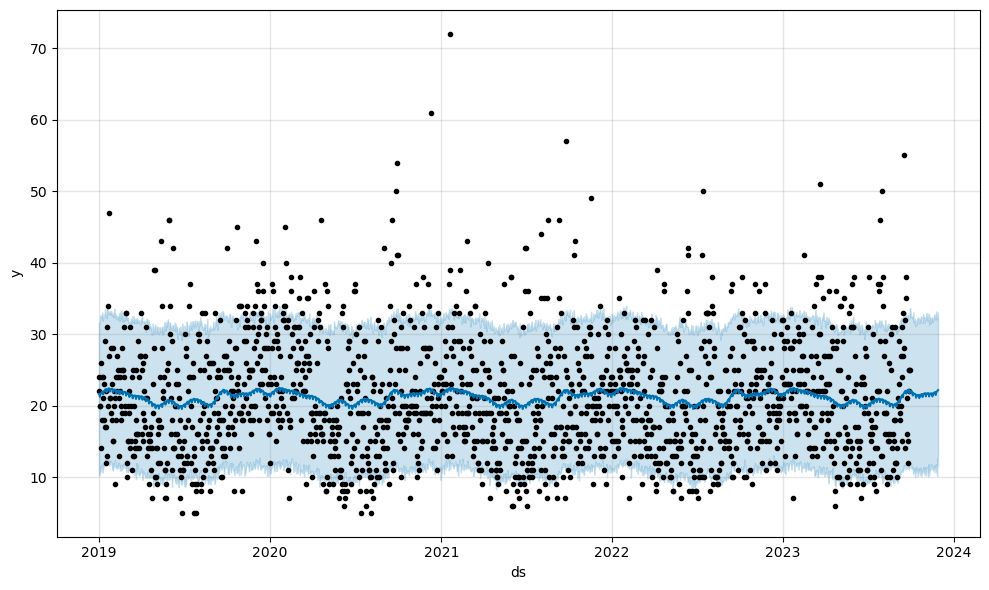

In [105]:
model = Prophet()
model.fit(df_p)

model = Prophet(#holidays=holidays,
               seasonality_mode="multiplicative",
               seasonality_prior_scale=0.01,
               holidays_prior_scale=0.01,
               changepoint_prior_scale=0.01)
model.fit(df_p)

# create dates to predict
future_dates = model.make_future_dataframe(periods=nobs)

# make predictions
pred = model.predict(future_dates)

model.plot(pred)
plt.show()

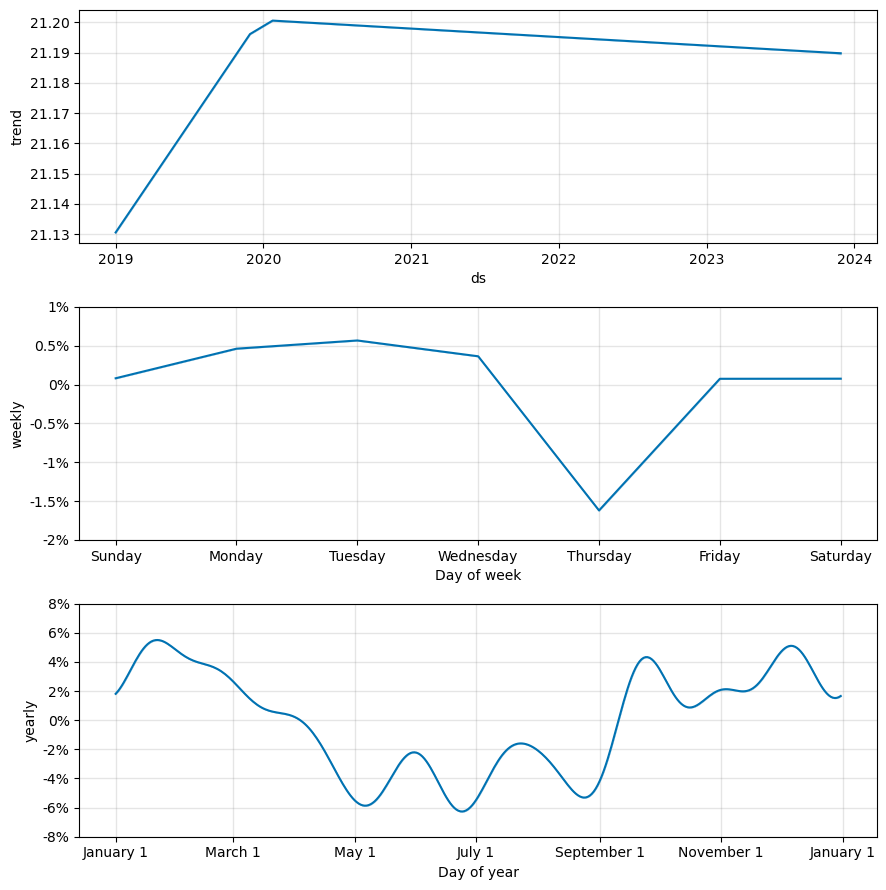

In [106]:
## two seasonal cycles: weekly and yearly
model.plot_components(pred)
plt.show()

The tuning model tells the wind speed time series has an upward trend. The seasonality as a percent of the trend are shown in the weekly and yearly plots. All days in a week have a positive effect from the seasonality, except Thursday. Throughout a year, there is likely much less windy from May to September than other months in a year.